# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

In [90]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.3, q=1):
    '''
    TODO: docstring describing purpose; inputs.
    '''
    # n = number of sets won
    n = 0
    lost = 0
    loss_factor = 1
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1
            n = n
        elif set_victor_array[index] == 3 - player:
            lost += 1
            # probability_array[index] = probability_array[index]/(2*lost)
            loss_factor = 1 / (q * lost)

        probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index]) * loss_factor

        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=1.02):
    '''
    TODO: docstring describing purpose; inputs.
    '''
    array = []

    # unforced error total
    n = 0
    #x = 1.001

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

        if (n >= 0):
            array.append (((s**n) - 1) / (s**n) + (1 / (s**n)) * momentum_array[index])
    return array

In [91]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum1, p2_momentum2
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] >= self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] >= self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] >= self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        print(winner, "won the game")

        verbose = False
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win):
        predicted_winner = 1+(np.diff(data, axis=1) )        

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        winner_number

        equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]


        match_total_sets = len(predicted_winner)+1
        match_length = [i for i in range(2, match_total_sets+1)]
        result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])
        result_array
        print("The length of the match is:",match_total_sets)
        print(result_array)

        return result_array

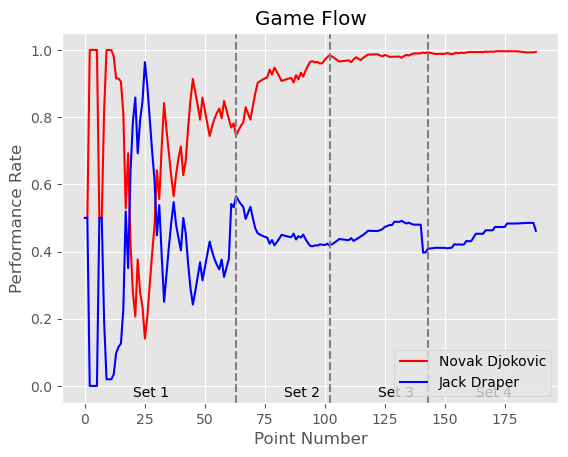

Novak Djokovic is winning going into set 3 with:  0.9843993794190776 momentum
Novak Djokovic is winning going into set 4 with:  0.9926423746928505 momentum
Novak Djokovic won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


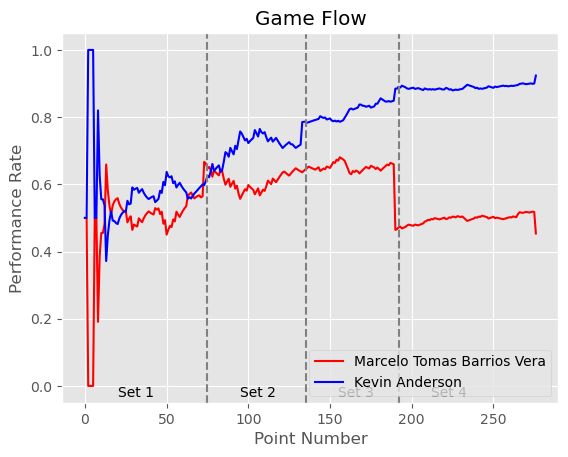

Kevin Anderson is winning going into set 3 with:  0.7866968199793082 momentum
Kevin Anderson is winning going into set 4 with:  0.8902786207383385 momentum
Kevin Anderson won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


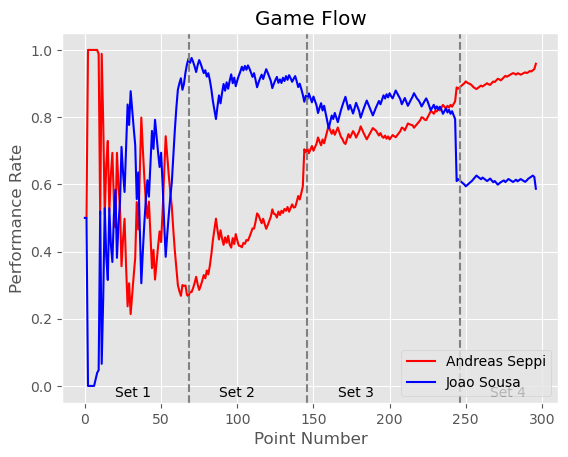

Joao Sousa is winning going into set 3 with:  0.8531694001547924 momentum
Andreas Seppi is winning going into set 4 with:  0.8889388034250508 momentum
Andreas Seppi won the game
The length of the match is: 4
[[0]
 [0]
 [1]]


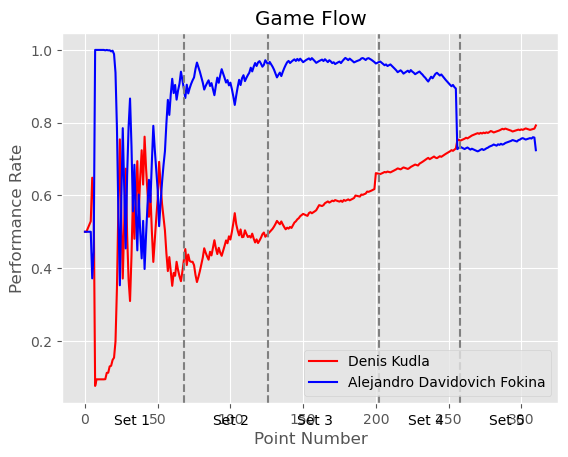

Alejandro Davidovich Fokina is winning going into set 3 with:  0.9588305596524661 momentum
Alejandro Davidovich Fokina is winning going into set 4 with:  0.966434085945813 momentum
Denis Kudla is winning going into set 5 with:  0.7503596670210023 momentum
Denis Kudla won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [1]]


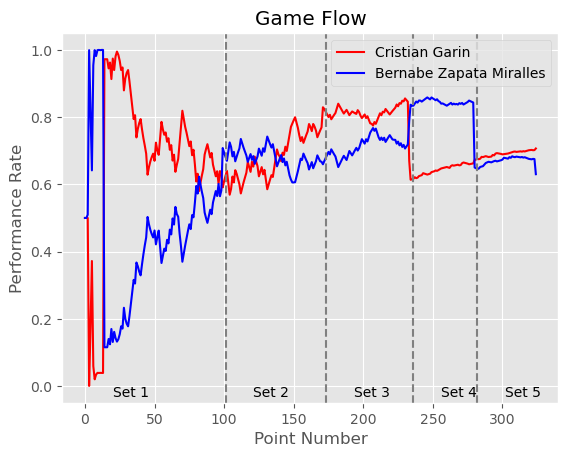

Cristian Garin is winning going into set 3 with:  0.816090304552805 momentum
Bernabe Zapata Miralles is winning going into set 4 with:  0.834117095603893 momentum
Cristian Garin is winning going into set 5 with:  0.6757011516559341 momentum
Cristian Garin won the game
The length of the match is: 5
[[0]
 [1]
 [0]
 [1]]


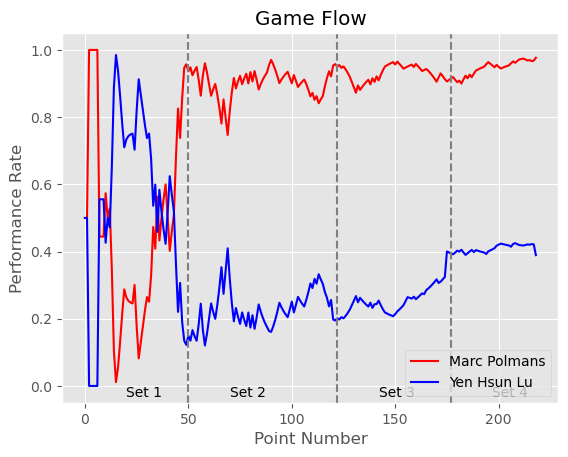

Marc Polmans is winning going into set 3 with:  0.9506509219620862 momentum
Marc Polmans is winning going into set 4 with:  0.915094222916875 momentum
Marc Polmans won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


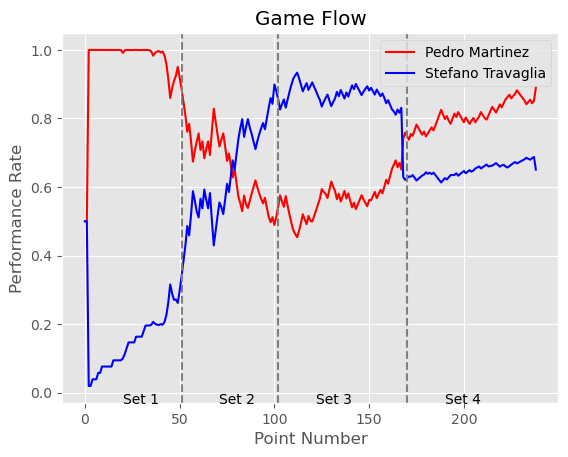

Stefano Travaglia is winning going into set 3 with:  0.855356632607539 momentum
Pedro Martinez is winning going into set 4 with:  0.7479748945591805 momentum
Pedro Martinez won the game
The length of the match is: 4
[[1]
 [0]
 [1]]


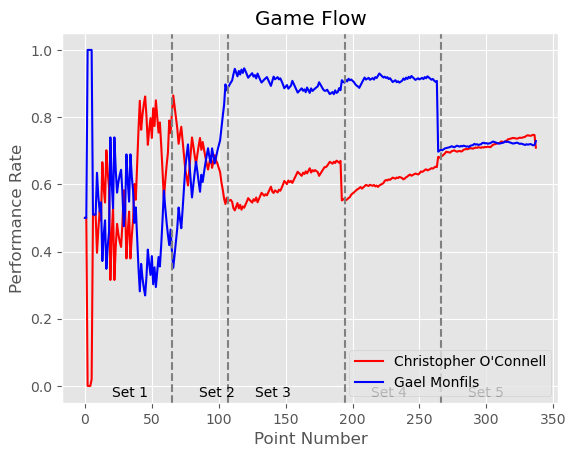

Gael Monfils is winning going into set 3 with:  0.8883591348997345 momentum
Gael Monfils is winning going into set 4 with:  0.9025372824520814 momentum
Gael Monfils is winning going into set 5 with:  0.7030146201662872 momentum
Gael Monfils won the game
The length of the match is: 5
[[0]
 [1]
 [1]
 [1]]


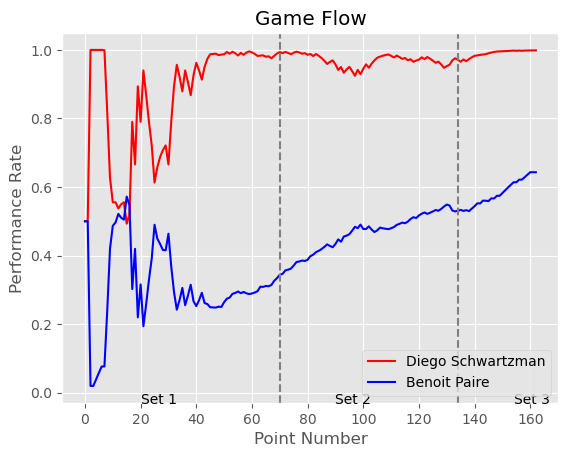

Diego Schwartzman is winning going into set 3 with:  0.9708695924681199 momentum
Diego Schwartzman won the game
The length of the match is: 3
[[1]
 [1]]


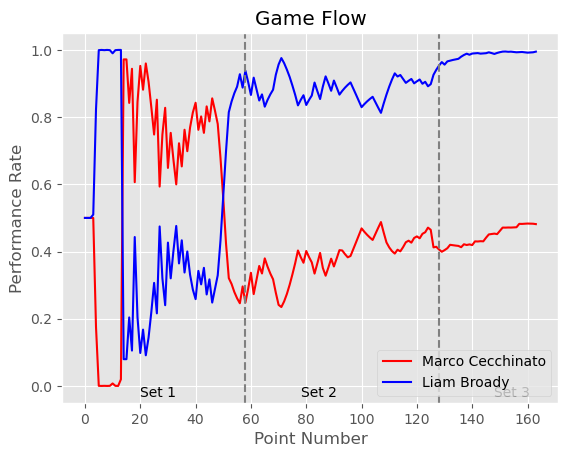

Liam Broady is winning going into set 3 with:  0.9533609109558255 momentum
Liam Broady won the game
The length of the match is: 3
[[1]
 [1]]


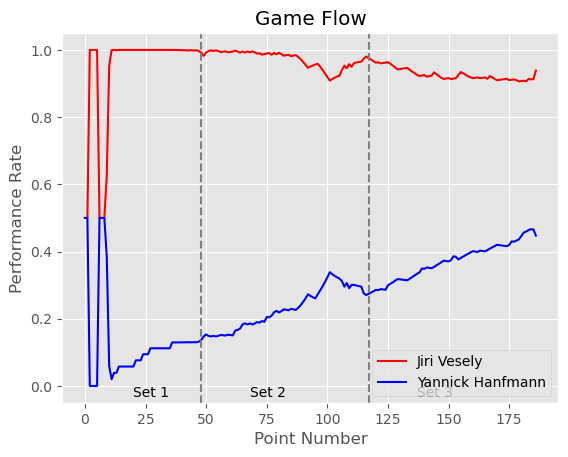

Jiri Vesely is winning going into set 3 with:  0.9760961250040774 momentum
Jiri Vesely won the game
The length of the match is: 3
[[1]
 [1]]


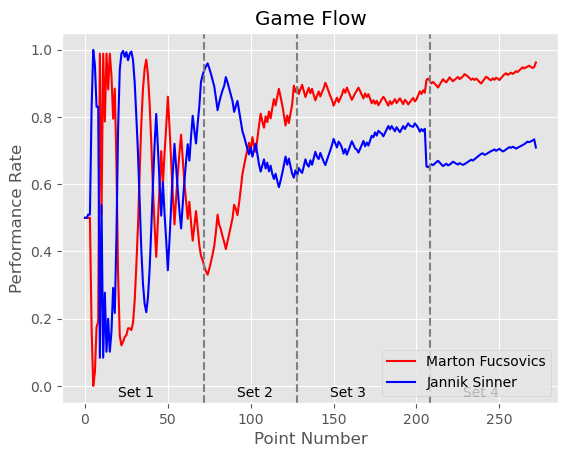

Marton Fucsovics is winning going into set 3 with:  0.8887820250305003 momentum
Marton Fucsovics is winning going into set 4 with:  0.9070073884591863 momentum
Marton Fucsovics won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


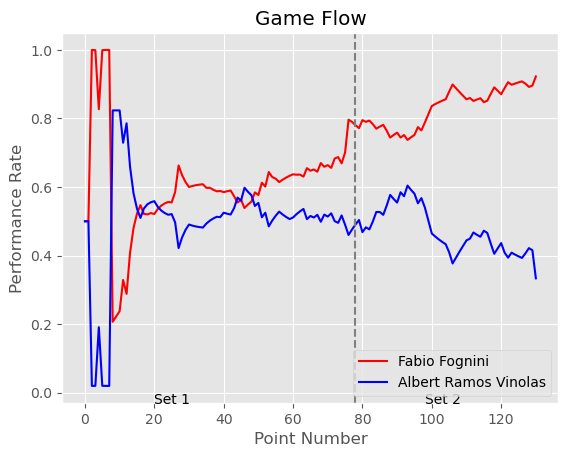

Fabio Fognini won the game
The length of the match is: 2
[[1]]


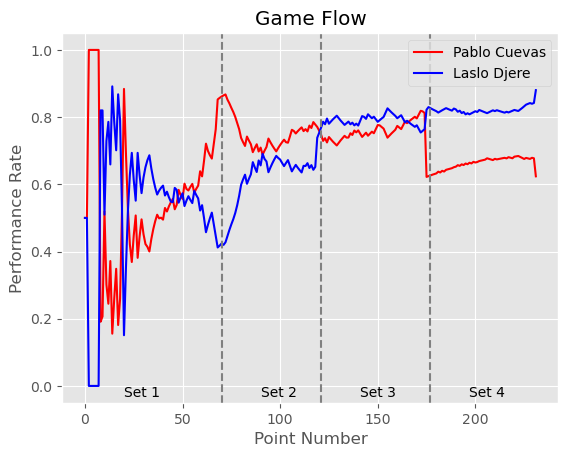

Laslo Djere is winning going into set 3 with:  0.7692770555305435 momentum
Laslo Djere is winning going into set 4 with:  0.8265605997669052 momentum
Laslo Djere won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


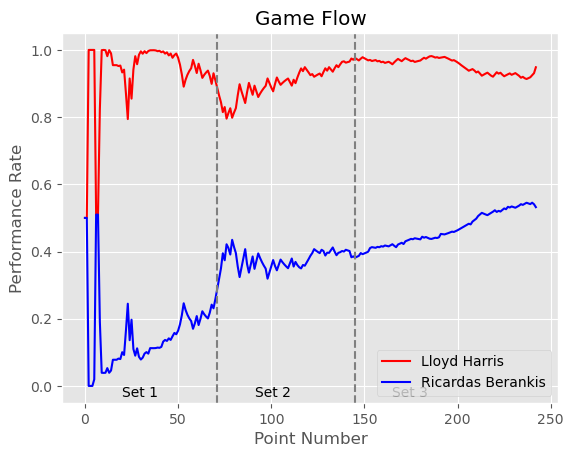

Lloyd Harris is winning going into set 3 with:  0.9758172776990849 momentum
Lloyd Harris won the game
The length of the match is: 3
[[1]
 [1]]


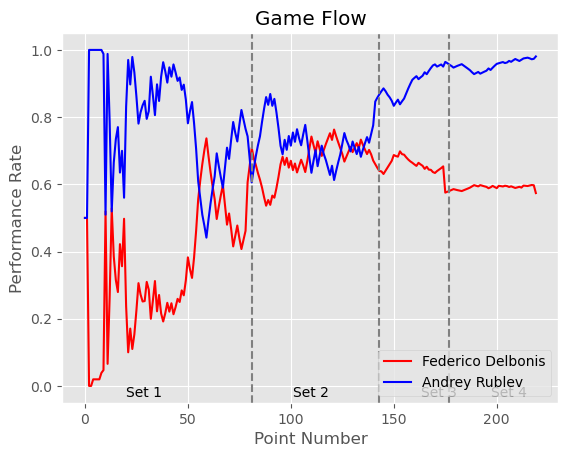

Andrey Rublev is winning going into set 3 with:  0.8679305586736286 momentum
Andrey Rublev is winning going into set 4 with:  0.956049574564365 momentum
Andrey Rublev won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


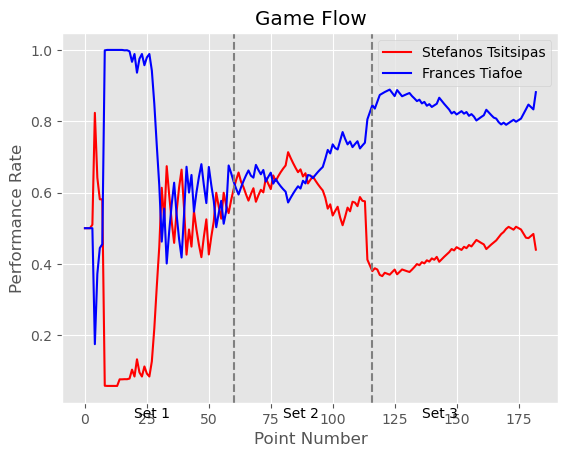

Frances Tiafoe is winning going into set 3 with:  0.8451253256487058 momentum
Frances Tiafoe won the game
The length of the match is: 3
[[1]
 [1]]


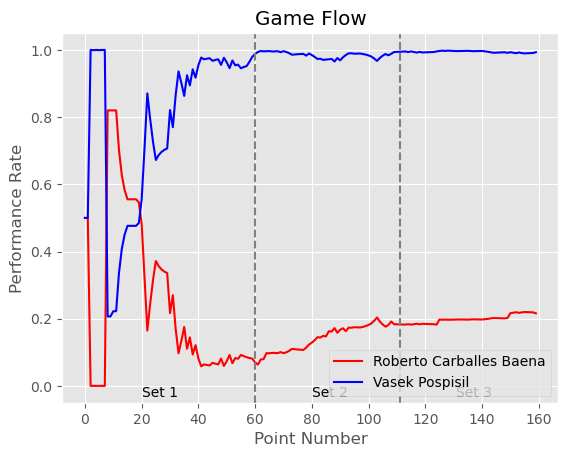

Vasek Pospisil is winning going into set 3 with:  0.9946728674130559 momentum
Vasek Pospisil won the game
The length of the match is: 3
[[1]
 [1]]


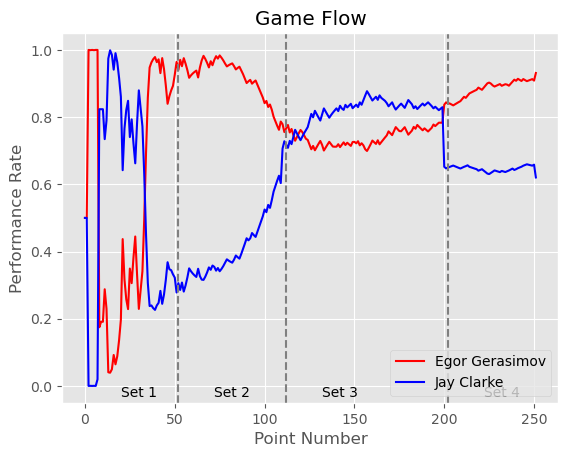

Egor Gerasimov is winning going into set 3 with:  0.76653545831596 momentum
Egor Gerasimov is winning going into set 4 with:  0.8406187381145129 momentum
Egor Gerasimov won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


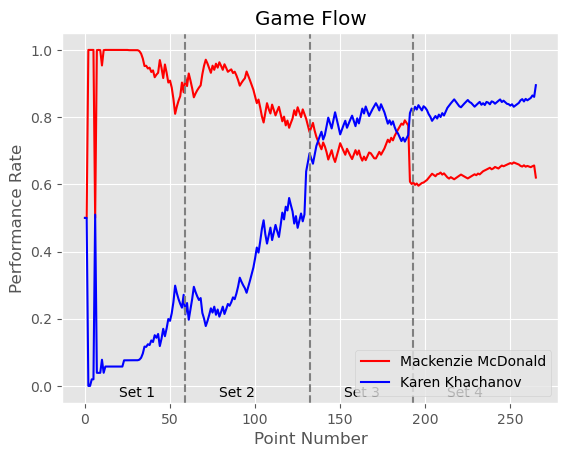

Mackenzie McDonald is winning going into set 3 with:  0.75562292892735 momentum
Karen Khachanov is winning going into set 4 with:  0.8174598186984801 momentum
Karen Khachanov won the game
The length of the match is: 4
[[0]
 [0]
 [1]]


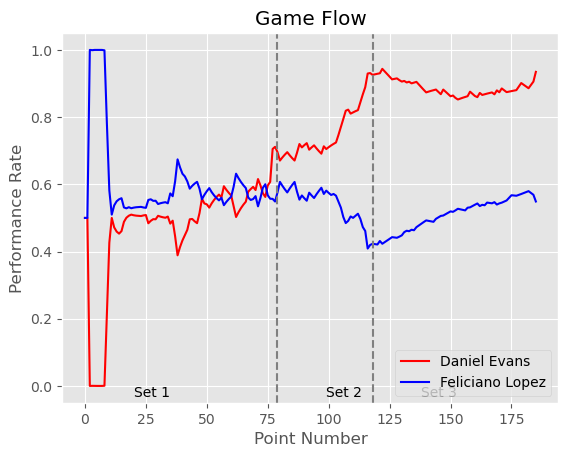

Daniel Evans is winning going into set 3 with:  0.925741127558626 momentum
Daniel Evans won the game
The length of the match is: 3
[[1]
 [1]]


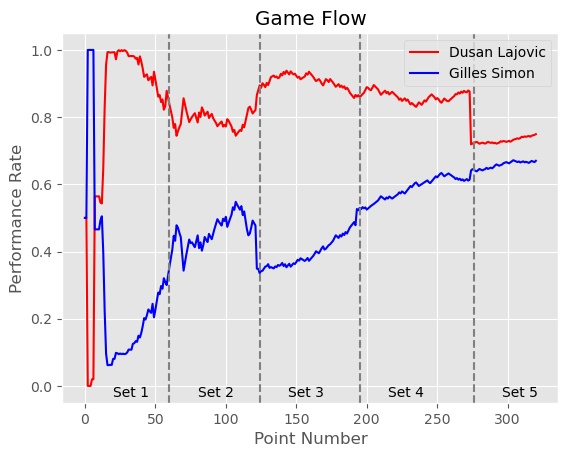

Dusan Lajovic is winning going into set 3 with:  0.8944952506158762 momentum
Dusan Lajovic is winning going into set 4 with:  0.8593890630454508 momentum
Dusan Lajovic is winning going into set 5 with:  0.7231367687451 momentum
Gilles Simon won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [0]]


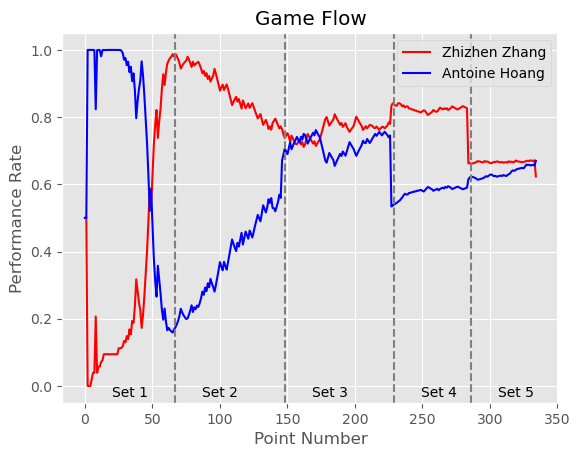

Zhizhen Zhang is winning going into set 3 with:  0.738126027744951 momentum
Zhizhen Zhang is winning going into set 4 with:  0.8376203854809039 momentum
Zhizhen Zhang is winning going into set 5 with:  0.6609526379067177 momentum
Antoine Hoang won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [0]]


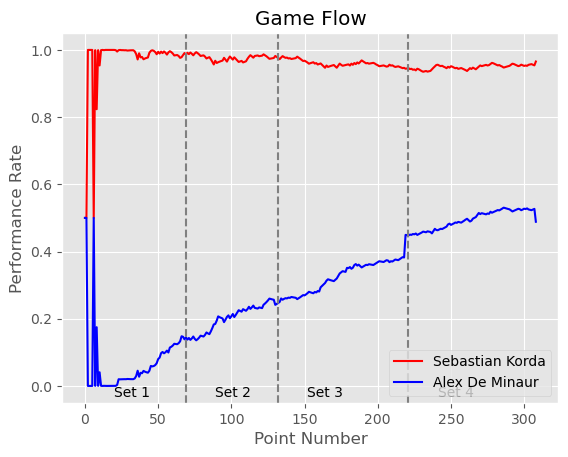

Sebastian Korda is winning going into set 3 with:  0.9758878975410993 momentum
Sebastian Korda is winning going into set 4 with:  0.9457956820123341 momentum
Sebastian Korda won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


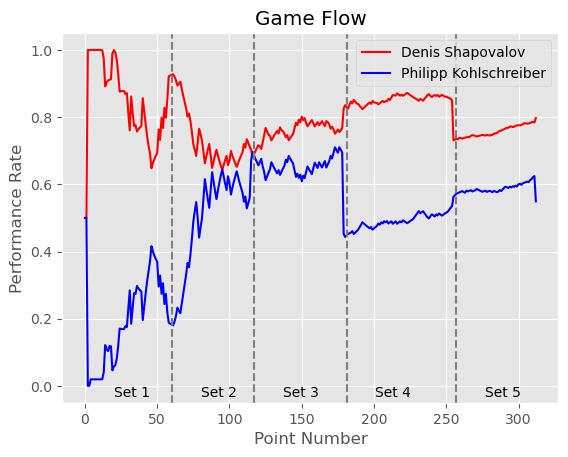

Denis Shapovalov is winning going into set 3 with:  0.6901504613450388 momentum
Denis Shapovalov is winning going into set 4 with:  0.8304196086606004 momentum
Denis Shapovalov is winning going into set 5 with:  0.7353221505109147 momentum
Denis Shapovalov won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [1]]


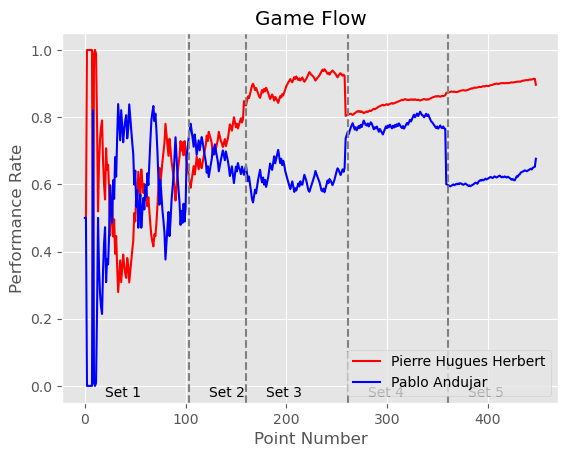

Pierre Hugues Herbert is winning going into set 3 with:  0.834777519281101 momentum
Pierre Hugues Herbert is winning going into set 4 with:  0.8061683175494314 momentum
Pierre Hugues Herbert is winning going into set 5 with:  0.8735007707137293 momentum
Pablo Andujar won the game
The length of the match is: 5
[[1]
 [0]
 [0]
 [0]]


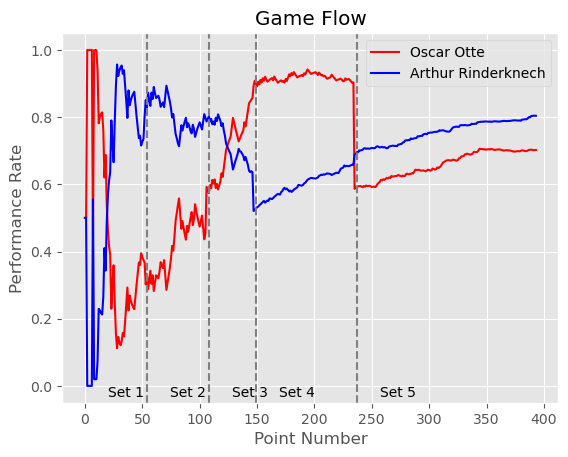

Arthur Rinderknech is winning going into set 3 with:  0.8024949285012397 momentum
Oscar Otte is winning going into set 4 with:  0.8996700119612332 momentum
Arthur Rinderknech is winning going into set 5 with:  0.695721227057541 momentum
Arthur Rinderknech won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [0]]


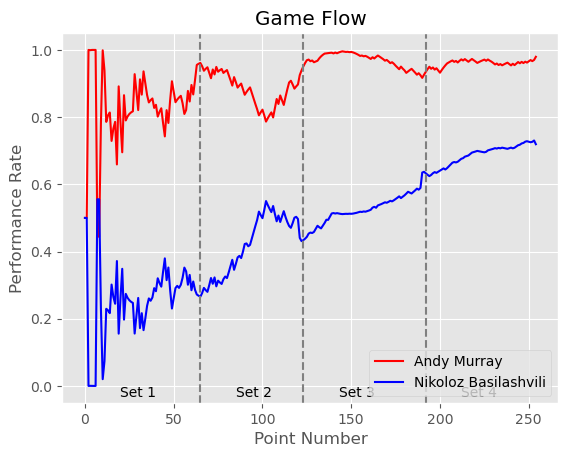

Andy Murray is winning going into set 3 with:  0.9507381125427402 momentum
Andy Murray is winning going into set 4 with:  0.9348487079299863 momentum
Andy Murray won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


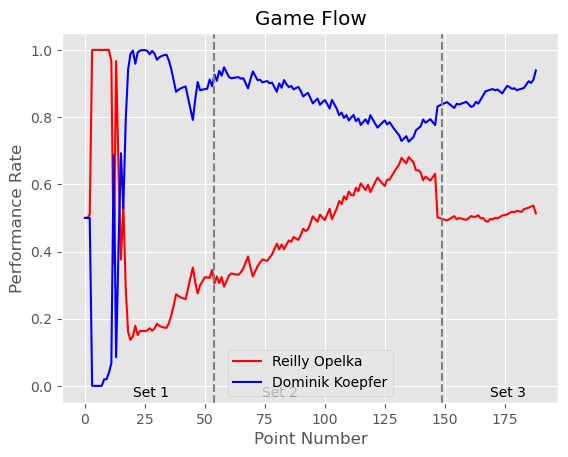

Dominik Koepfer is winning going into set 3 with:  0.8385256174078239 momentum
Dominik Koepfer won the game
The length of the match is: 3
[[1]
 [1]]


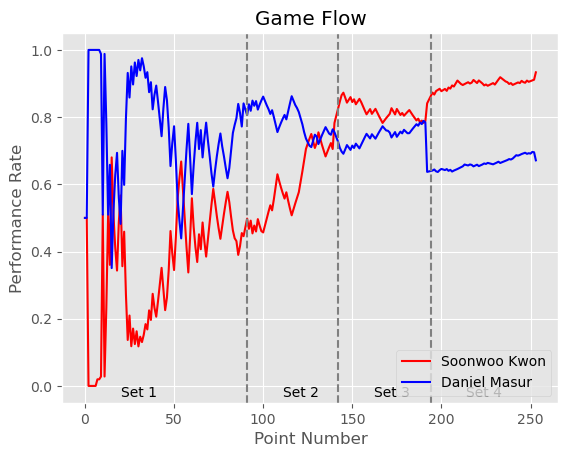

Soonwoo Kwon is winning going into set 3 with:  0.8252978664180604 momentum
Soonwoo Kwon is winning going into set 4 with:  0.8623305266220155 momentum
Soonwoo Kwon won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


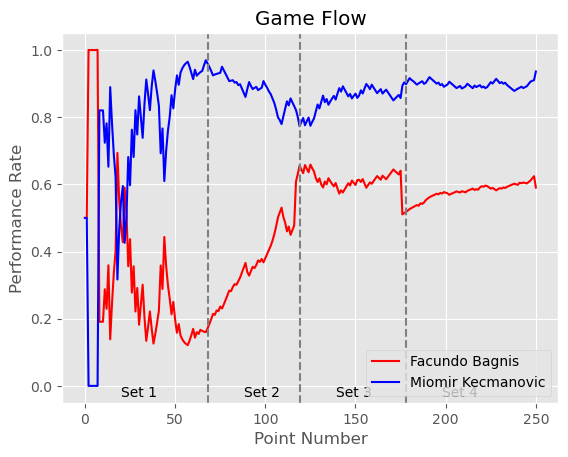

Miomir Kecmanovic is winning going into set 3 with:  0.7729957197246284 momentum
Miomir Kecmanovic is winning going into set 4 with:  0.897839319196612 momentum
Miomir Kecmanovic won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


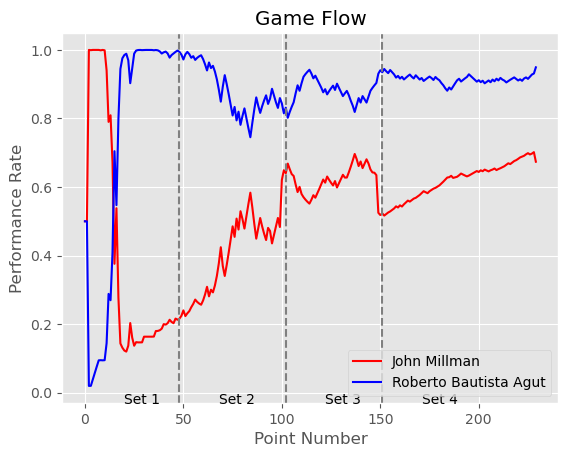

Roberto Bautista Agut is winning going into set 3 with:  0.8313581073290639 momentum
Roberto Bautista Agut is winning going into set 4 with:  0.9349736212334169 momentum
Roberto Bautista Agut won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


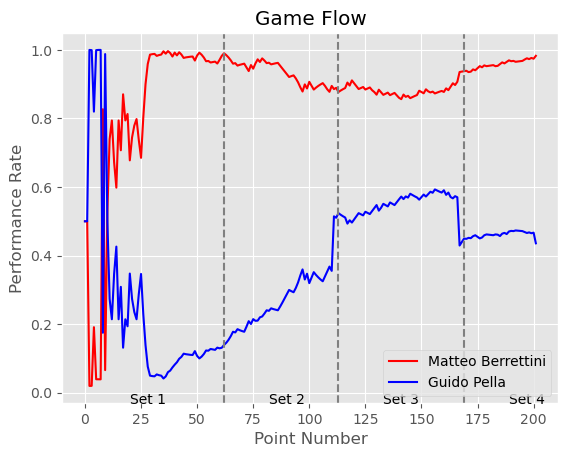

Matteo Berrettini is winning going into set 3 with:  0.8772243565863453 momentum
Matteo Berrettini is winning going into set 4 with:  0.9380483124268131 momentum
Matteo Berrettini won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


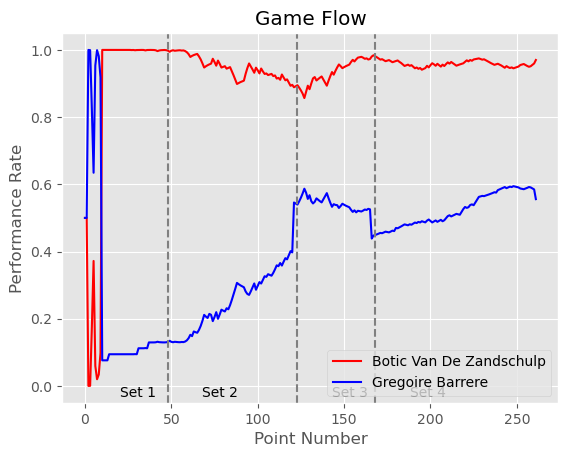

Botic Van De Zandschulp is winning going into set 3 with:  0.8949520264140431 momentum
Botic Van De Zandschulp is winning going into set 4 with:  0.9811995225263335 momentum
Botic Van De Zandschulp won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


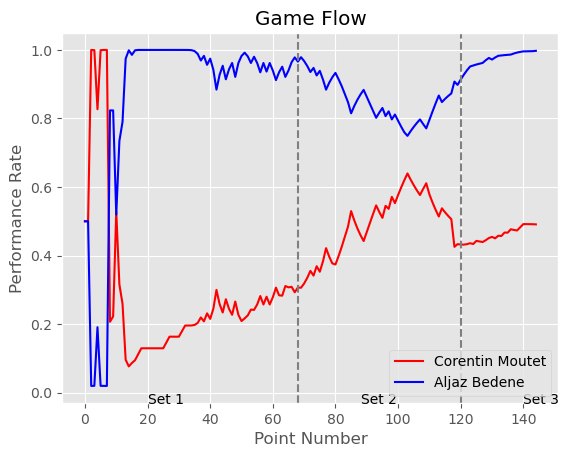

Aljaz Bedene is winning going into set 3 with:  0.9135301326130878 momentum
Aljaz Bedene won the game
The length of the match is: 3
[[1]
 [1]]


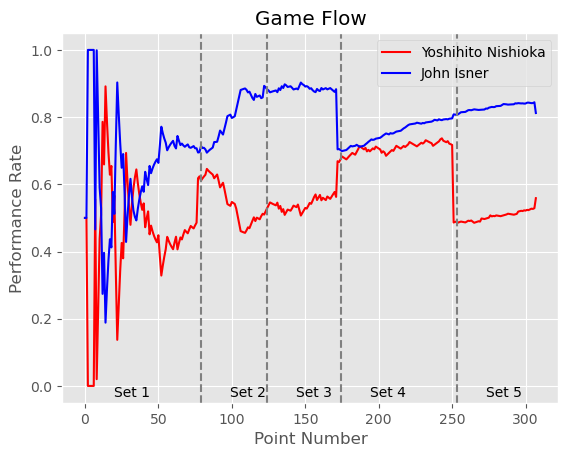

John Isner is winning going into set 3 with:  0.8827314059189414 momentum
John Isner is winning going into set 4 with:  0.7021589828439652 momentum
John Isner is winning going into set 5 with:  0.8068407413526846 momentum
Yoshihito Nishioka won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [0]]


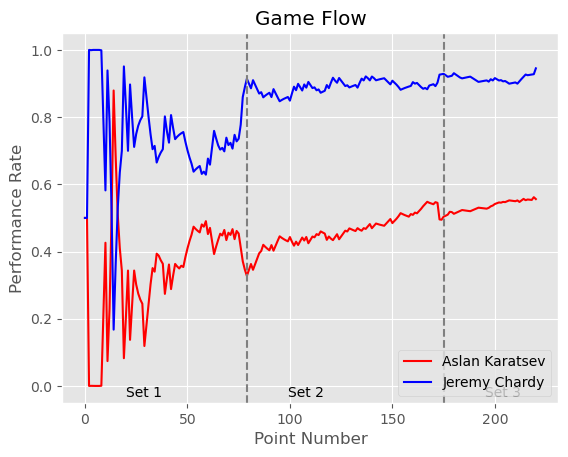

Jeremy Chardy is winning going into set 3 with:  0.928798772389418 momentum
Jeremy Chardy won the game
The length of the match is: 3
[[1]
 [1]]


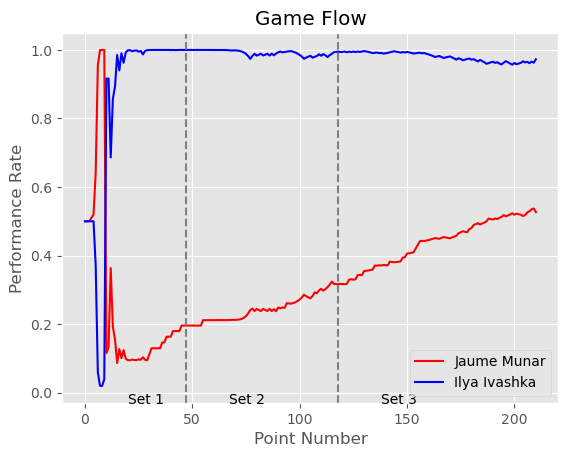

Ilya Ivashka is winning going into set 3 with:  0.9950692374858213 momentum
Ilya Ivashka won the game
The length of the match is: 3
[[1]
 [1]]


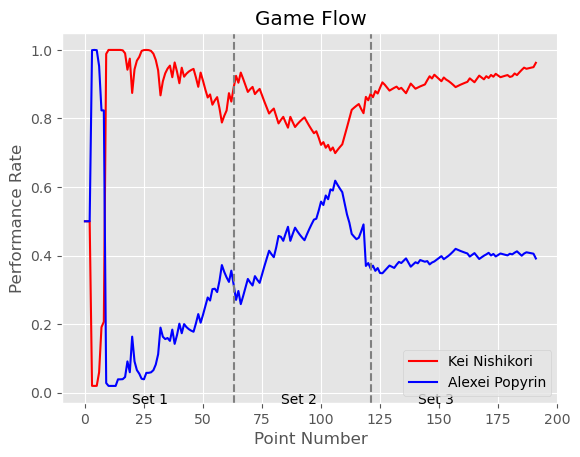

Kei Nishikori is winning going into set 3 with:  0.8717257971613488 momentum
Kei Nishikori won the game
The length of the match is: 3
[[1]
 [1]]


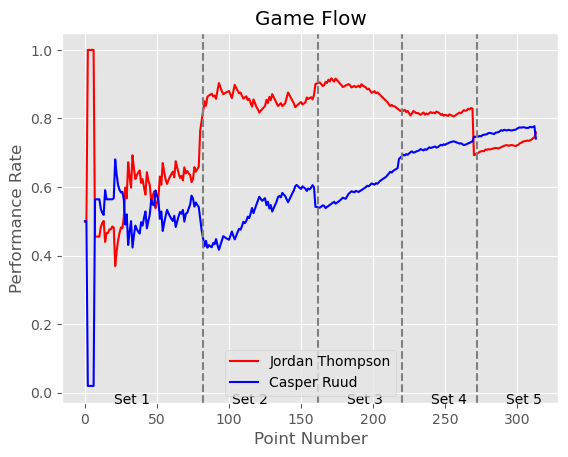

Jordan Thompson is winning going into set 3 with:  0.9037811164369114 momentum
Jordan Thompson is winning going into set 4 with:  0.8253151603850799 momentum
Casper Ruud is winning going into set 5 with:  0.7480112317299683 momentum
Jordan Thompson won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [0]]


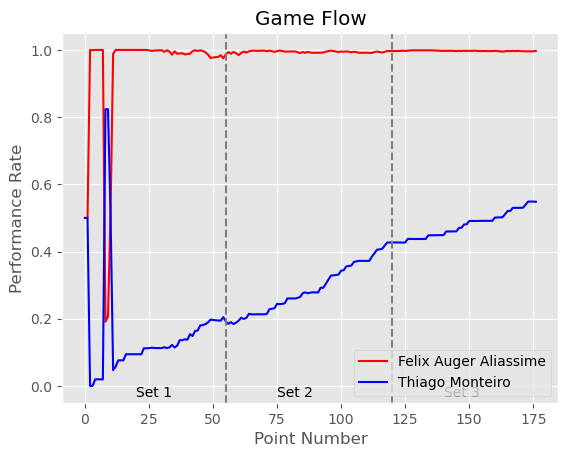

Felix Auger Aliassime is winning going into set 3 with:  0.9966024424488283 momentum
Felix Auger Aliassime won the game
The length of the match is: 3
[[1]
 [1]]


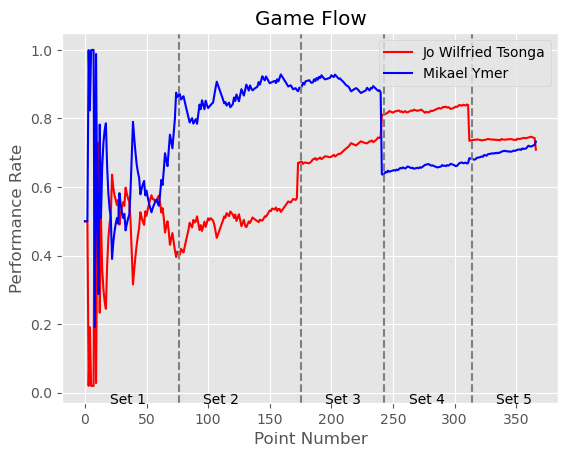

Mikael Ymer is winning going into set 3 with:  0.8843373675270044 momentum
Jo Wilfried Tsonga is winning going into set 4 with:  0.8112556620655444 momentum
Jo Wilfried Tsonga is winning going into set 5 with:  0.7365345408860833 momentum
Mikael Ymer won the game
The length of the match is: 5
[[1]
 [1]
 [0]
 [0]]


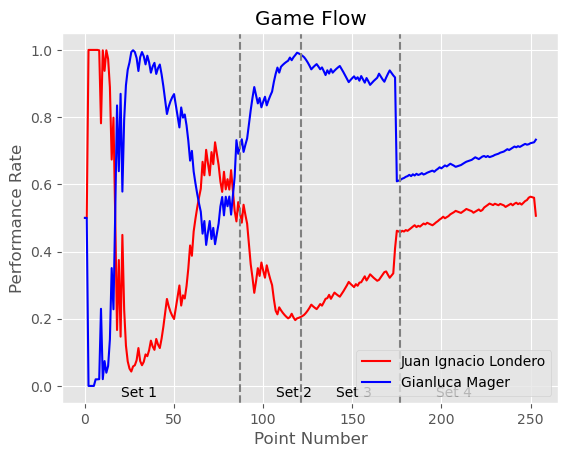

Gianluca Mager is winning going into set 3 with:  0.9863799724303249 momentum
Gianluca Mager is winning going into set 4 with:  0.6130583084718861 momentum
Gianluca Mager won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


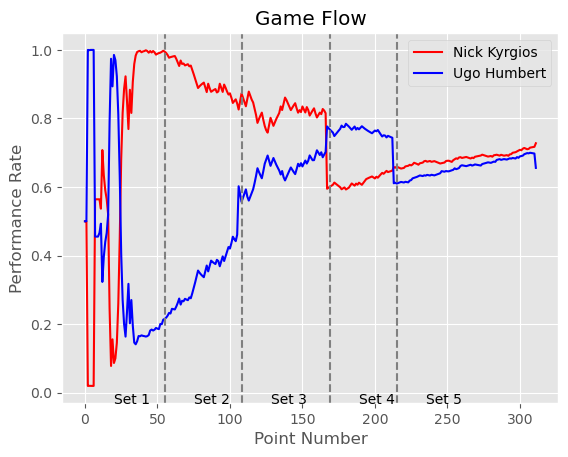

Nick Kyrgios is winning going into set 3 with:  0.8733726194847347 momentum
Ugo Humbert is winning going into set 4 with:  0.7672456228661675 momentum
Nick Kyrgios is winning going into set 5 with:  0.6593644146912079 momentum
Nick Kyrgios won the game
The length of the match is: 5
[[1]
 [1]
 [0]
 [1]]


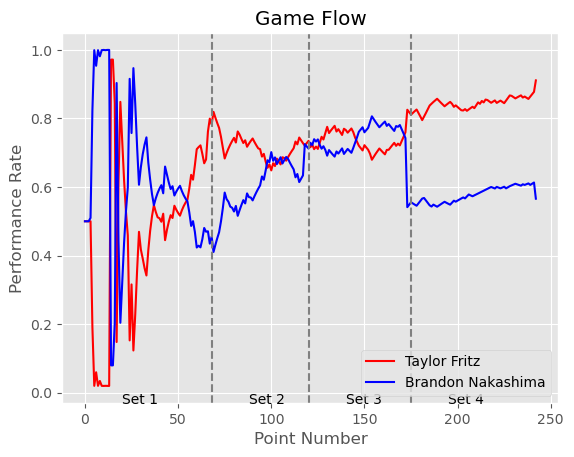

Taylor Fritz is winning going into set 3 with:  0.7345502120011674 momentum
Taylor Fritz is winning going into set 4 with:  0.8111978629357399 momentum
Taylor Fritz won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


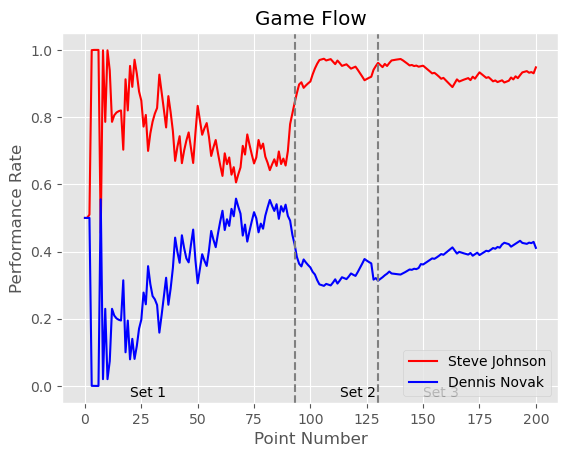

Steve Johnson is winning going into set 3 with:  0.9615052388123729 momentum
Steve Johnson won the game
The length of the match is: 3
[[1]
 [1]]


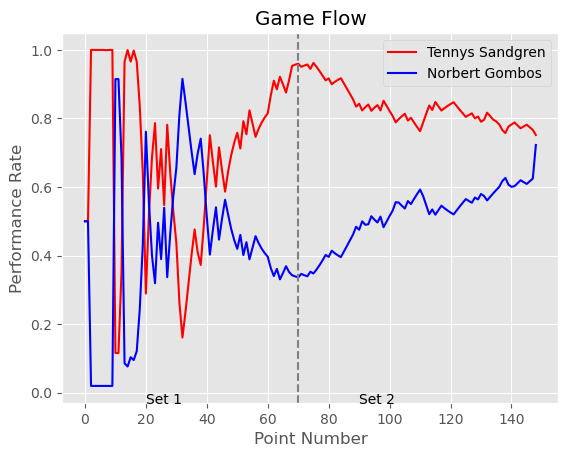

Norbert Gombos won the game
The length of the match is: 2
[[0]]


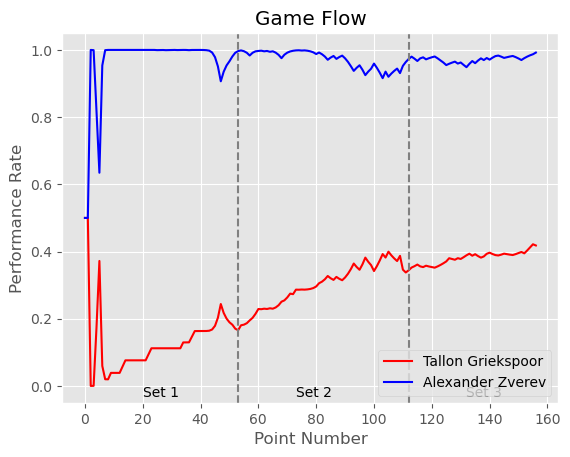

Alexander Zverev is winning going into set 3 with:  0.9730309629715735 momentum
Alexander Zverev won the game
The length of the match is: 3
[[1]
 [1]]


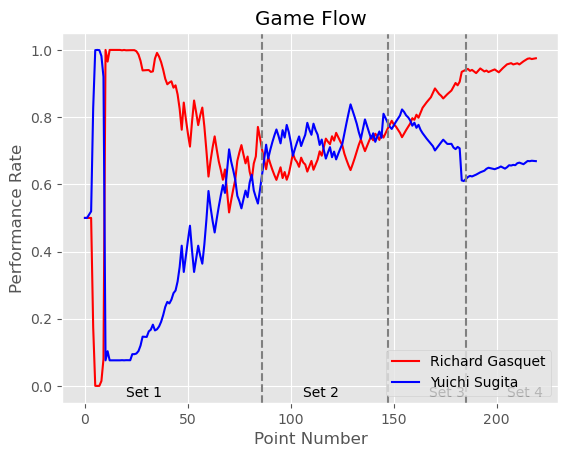

Yuichi Sugita is winning going into set 3 with:  0.7839761660597747 momentum
Richard Gasquet is winning going into set 4 with:  0.9408225216816274 momentum
Yuichi Sugita won the game
The length of the match is: 4
[[0]
 [0]
 [0]]


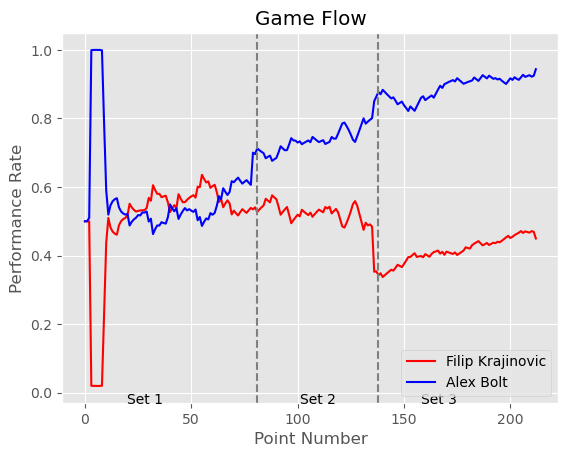

Alex Bolt is winning going into set 3 with:  0.8772890205290551 momentum
Alex Bolt won the game
The length of the match is: 3
[[1]
 [1]]


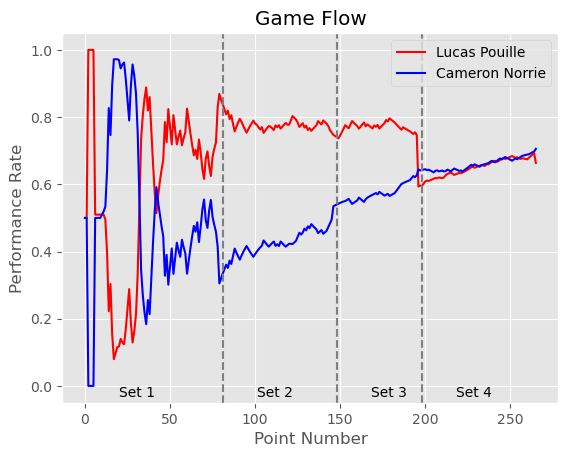

Lucas Pouille is winning going into set 3 with:  0.7401361822060689 momentum
Cameron Norrie is winning going into set 4 with:  0.6425803945970545 momentum
Cameron Norrie won the game
The length of the match is: 4
[[0]
 [0]
 [1]]


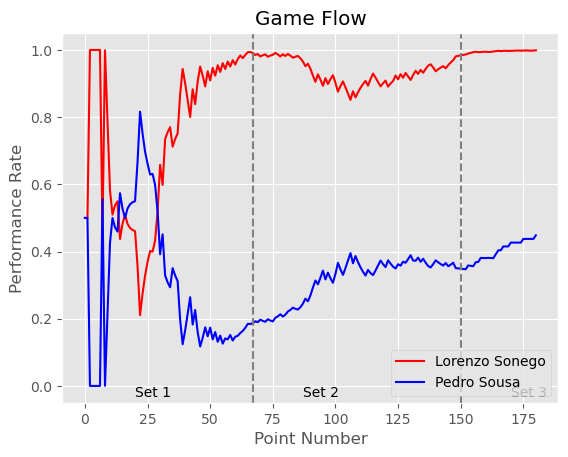

Lorenzo Sonego is winning going into set 3 with:  0.9839848932567867 momentum
Lorenzo Sonego won the game
The length of the match is: 3
[[1]
 [1]]


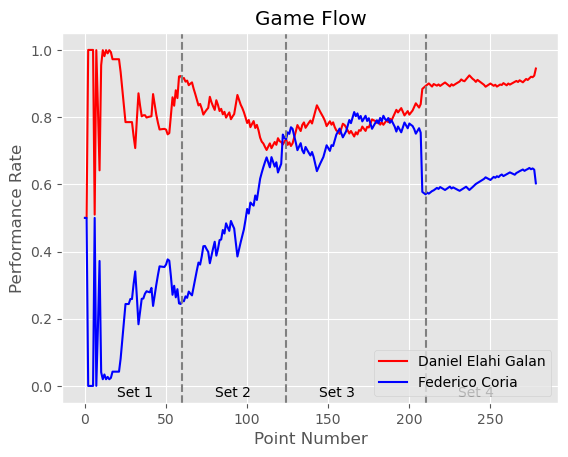

Daniel Elahi Galan is winning going into set 3 with:  0.7343984646834443 momentum
Daniel Elahi Galan is winning going into set 4 with:  0.892503079201625 momentum
Daniel Elahi Galan won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


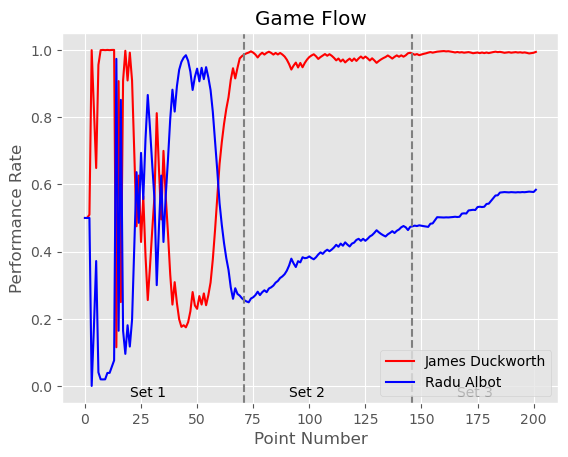

James Duckworth is winning going into set 3 with:  0.9888908812650052 momentum
James Duckworth won the game
The length of the match is: 3
[[1]
 [1]]


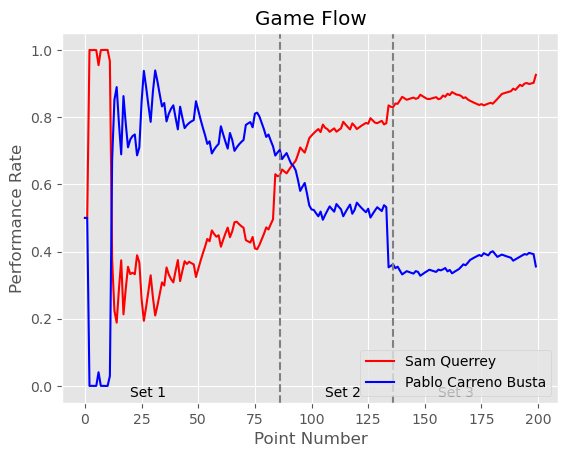

Sam Querrey is winning going into set 3 with:  0.8301011005777085 momentum
Sam Querrey won the game
The length of the match is: 3
[[0]
 [1]]


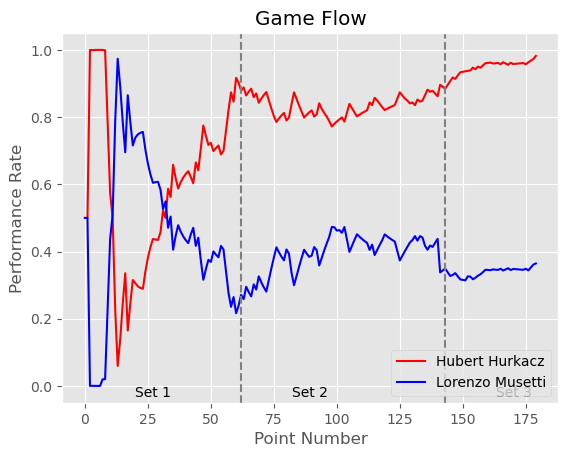

Hubert Hurkacz is winning going into set 3 with:  0.8842849961818007 momentum
Hubert Hurkacz won the game
The length of the match is: 3
[[1]
 [1]]


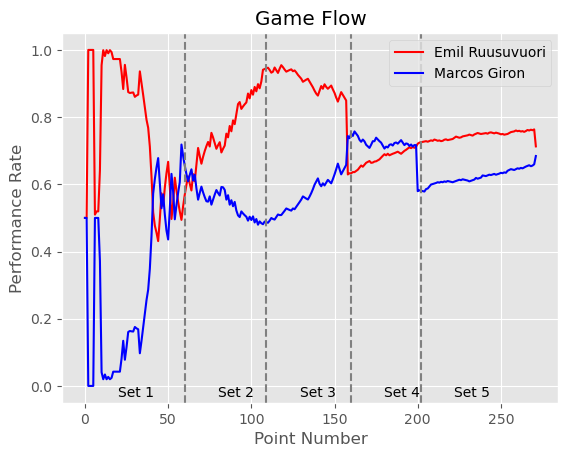

Emil Ruusuvuori is winning going into set 3 with:  0.9452941650322739 momentum
Marcos Giron is winning going into set 4 with:  0.750580472679014 momentum
Emil Ruusuvuori is winning going into set 5 with:  0.7252756371651092 momentum
Marcos Giron won the game
The length of the match is: 5
[[1]
 [0]
 [1]
 [0]]


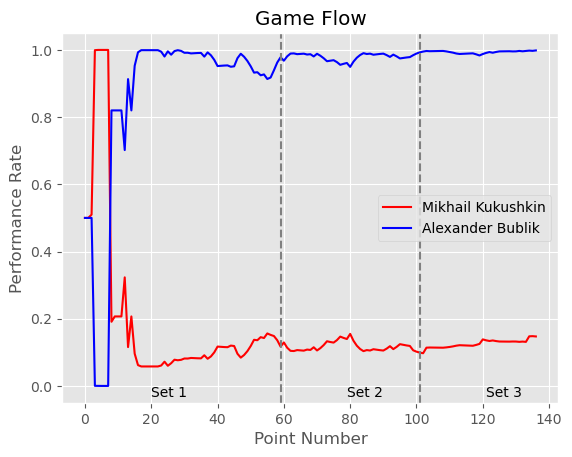

Alexander Bublik is winning going into set 3 with:  0.9926986762911154 momentum
Alexander Bublik won the game
The length of the match is: 3
[[1]
 [1]]


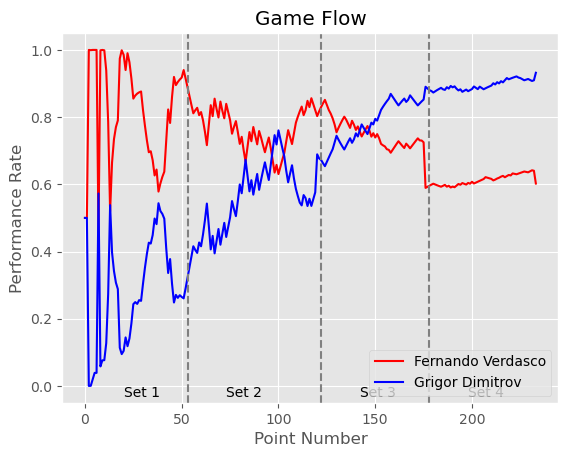

Fernando Verdasco is winning going into set 3 with:  0.8295920760787782 momentum
Grigor Dimitrov is winning going into set 4 with:  0.8802017656321466 momentum
Grigor Dimitrov won the game
The length of the match is: 4
[[0]
 [0]
 [1]]


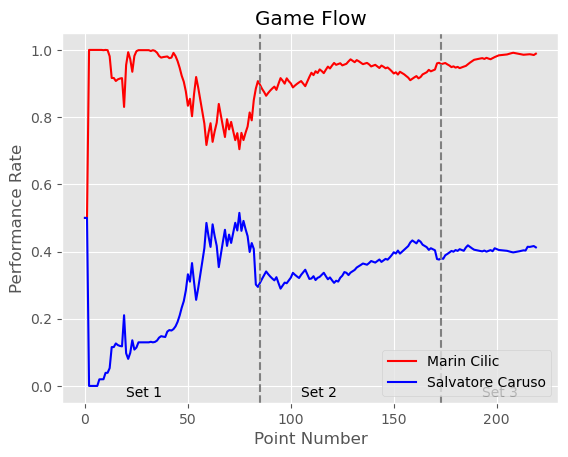

Marin Cilic is winning going into set 3 with:  0.9576320986806184 momentum
Marin Cilic won the game
The length of the match is: 3
[[1]
 [1]]


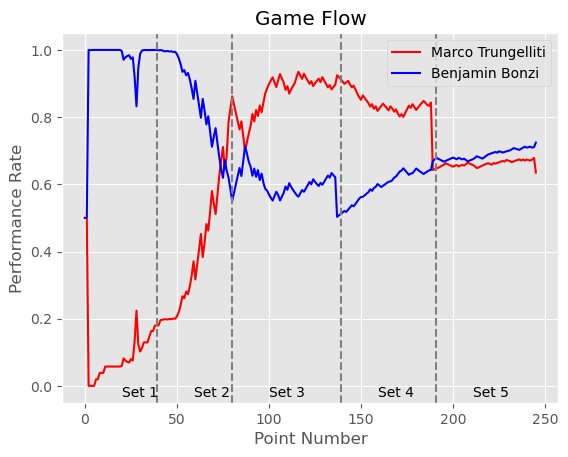

Marco Trungelliti is winning going into set 3 with:  0.8619586868830265 momentum
Marco Trungelliti is winning going into set 4 with:  0.9131757423301341 momentum
Benjamin Bonzi is winning going into set 5 with:  0.6789356831470706 momentum
Benjamin Bonzi won the game
The length of the match is: 5
[[1]
 [0]
 [0]
 [1]]


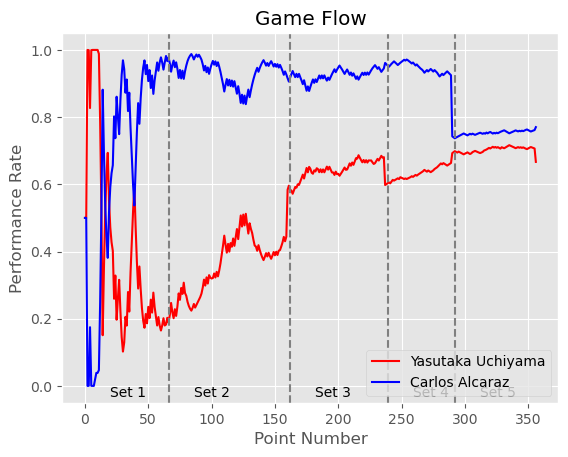

Carlos Alcaraz is winning going into set 3 with:  0.9174360776382049 momentum
Carlos Alcaraz is winning going into set 4 with:  0.9531200318943533 momentum
Carlos Alcaraz is winning going into set 5 with:  0.7371200049564605 momentum
Carlos Alcaraz won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [1]]


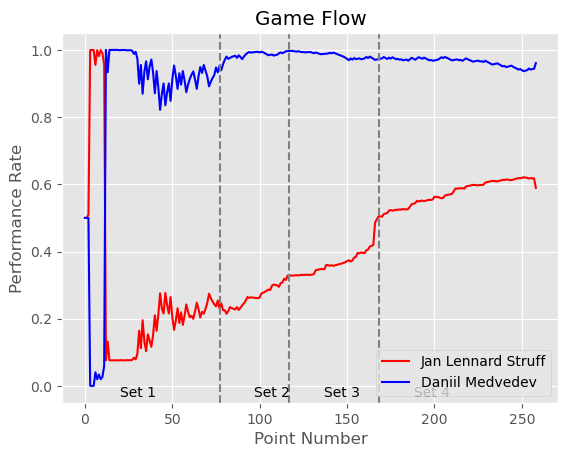

Daniil Medvedev is winning going into set 3 with:  0.996725599754248 momentum
Daniil Medvedev is winning going into set 4 with:  0.9727797302008955 momentum
Daniil Medvedev won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


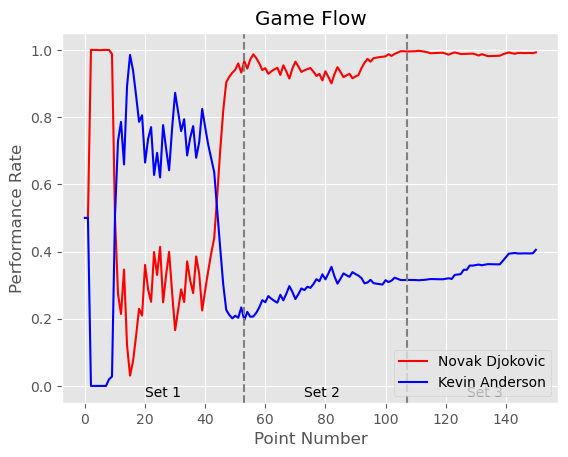

Novak Djokovic is winning going into set 3 with:  0.9953040695241198 momentum
Novak Djokovic won the game
The length of the match is: 3
[[1]
 [1]]


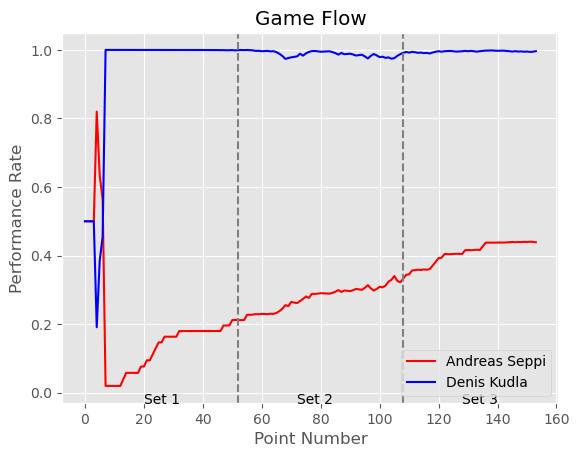

Denis Kudla is winning going into set 3 with:  0.9914062432350015 momentum
Denis Kudla won the game
The length of the match is: 3
[[1]
 [1]]


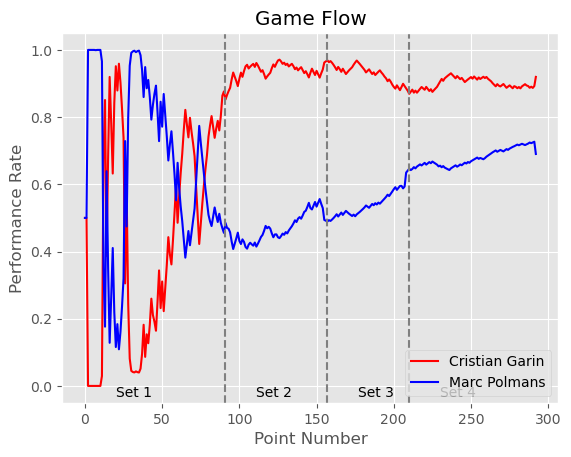

Cristian Garin is winning going into set 3 with:  0.9690427237001384 momentum
Cristian Garin is winning going into set 4 with:  0.8693874245260569 momentum
Cristian Garin won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


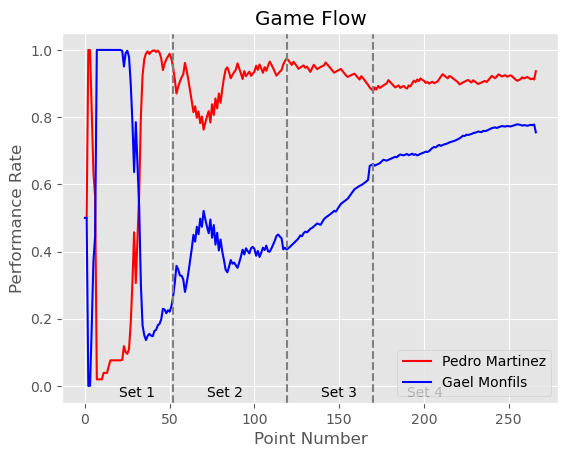

Pedro Martinez is winning going into set 3 with:  0.9748798858879272 momentum
Pedro Martinez is winning going into set 4 with:  0.8773358482692779 momentum
Pedro Martinez won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


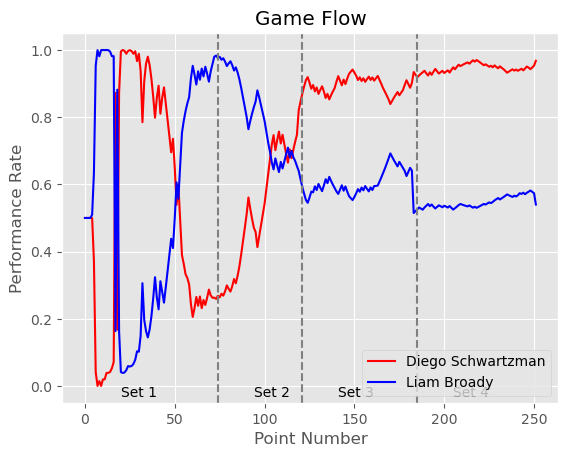

Diego Schwartzman is winning going into set 3 with:  0.8698956427074026 momentum
Diego Schwartzman is winning going into set 4 with:  0.9187143123222097 momentum
Diego Schwartzman won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


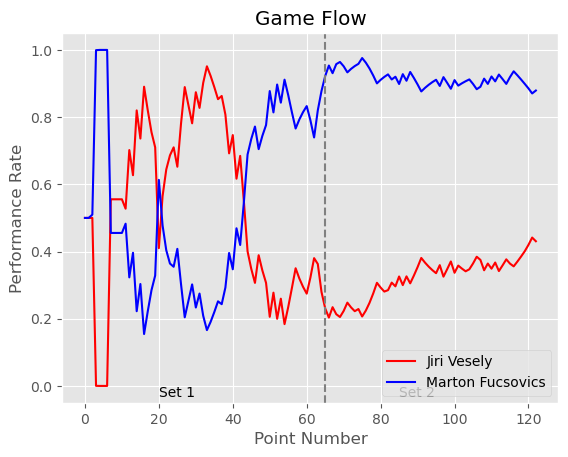

Marton Fucsovics won the game
The length of the match is: 2
[[0]]


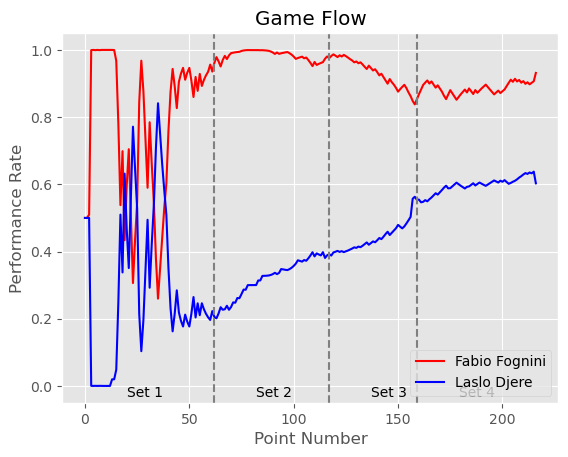

Fabio Fognini is winning going into set 3 with:  0.9755554179711142 momentum
Fabio Fognini is winning going into set 4 with:  0.8532882714111794 momentum
Fabio Fognini won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


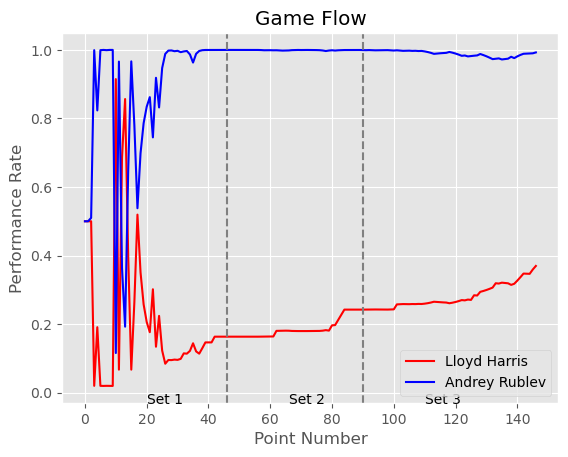

Andrey Rublev is winning going into set 3 with:  0.9995833580743364 momentum
Andrey Rublev won the game
The length of the match is: 3
[[1]
 [1]]


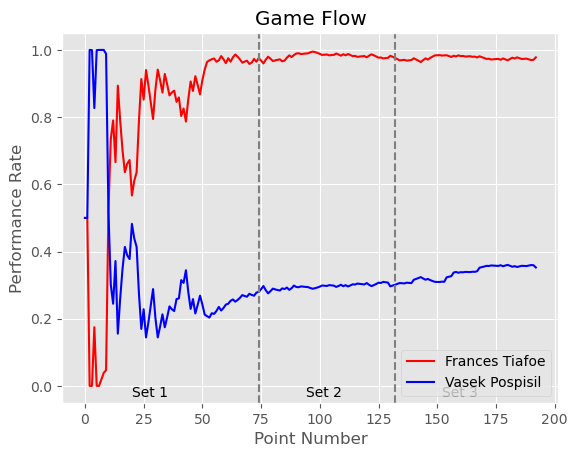

Frances Tiafoe is winning going into set 3 with:  0.9763679409618938 momentum
Frances Tiafoe won the game
The length of the match is: 3
[[1]
 [1]]


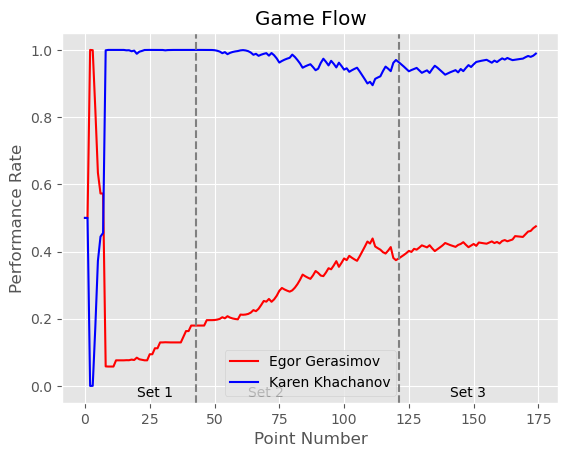

Karen Khachanov is winning going into set 3 with:  0.9640723494606117 momentum
Karen Khachanov won the game
The length of the match is: 3
[[1]
 [1]]


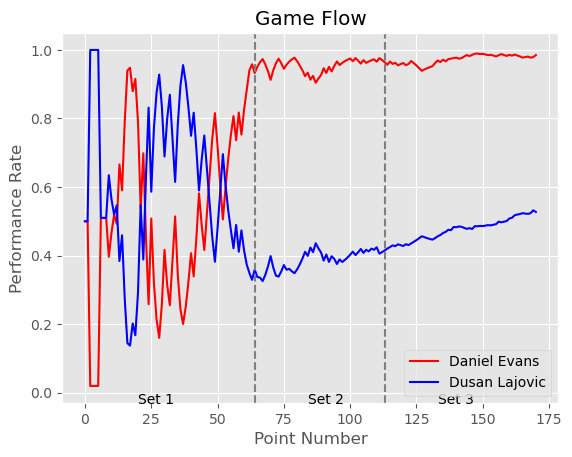

Daniel Evans is winning going into set 3 with:  0.9639766992005062 momentum
Daniel Evans won the game
The length of the match is: 3
[[1]
 [1]]


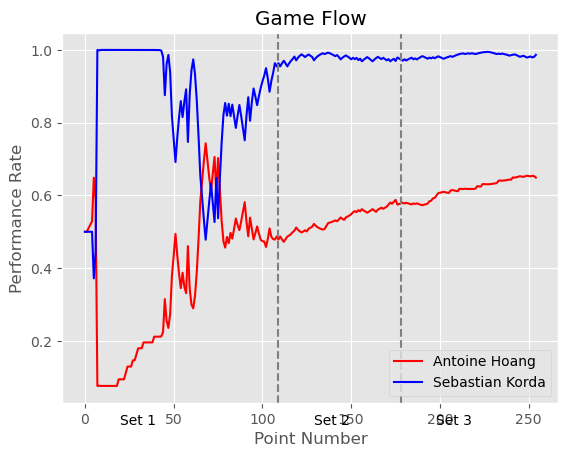

Sebastian Korda is winning going into set 3 with:  0.973206744868726 momentum
Sebastian Korda won the game
The length of the match is: 3
[[1]
 [1]]


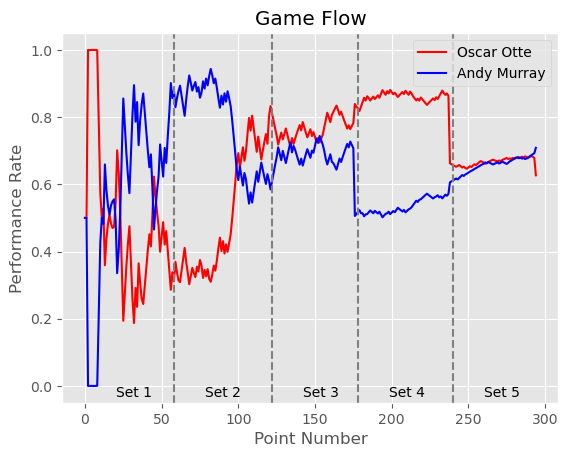

Oscar Otte is winning going into set 3 with:  0.8104615094284608 momentum
Oscar Otte is winning going into set 4 with:  0.8259282218376243 momentum
Oscar Otte is winning going into set 5 with:  0.6571100701087089 momentum
Andy Murray won the game
The length of the match is: 5
[[1]
 [0]
 [0]
 [0]]


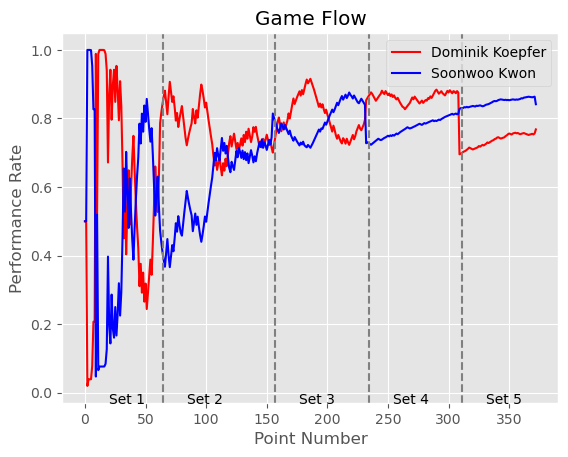

Soonwoo Kwon is winning going into set 3 with:  0.7892016983374888 momentum
Dominik Koepfer is winning going into set 4 with:  0.8651147909112434 momentum
Soonwoo Kwon is winning going into set 5 with:  0.8291948614363691 momentum
Dominik Koepfer won the game
The length of the match is: 5
[[1]
 [0]
 [1]
 [0]]


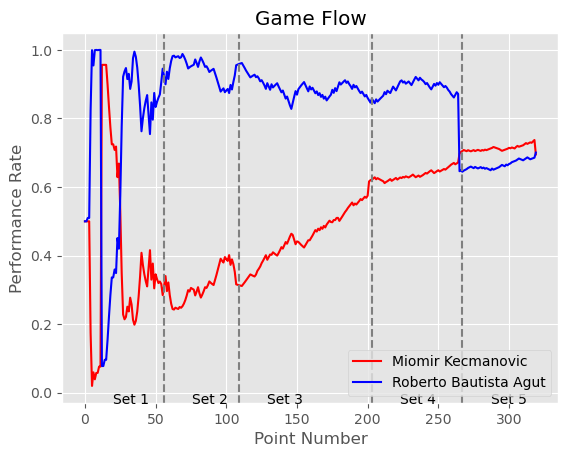

Roberto Bautista Agut is winning going into set 3 with:  0.9589620910679567 momentum
Roberto Bautista Agut is winning going into set 4 with:  0.8577856110932068 momentum
Miomir Kecmanovic is winning going into set 5 with:  0.7051076973214041 momentum
Roberto Bautista Agut won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [0]]


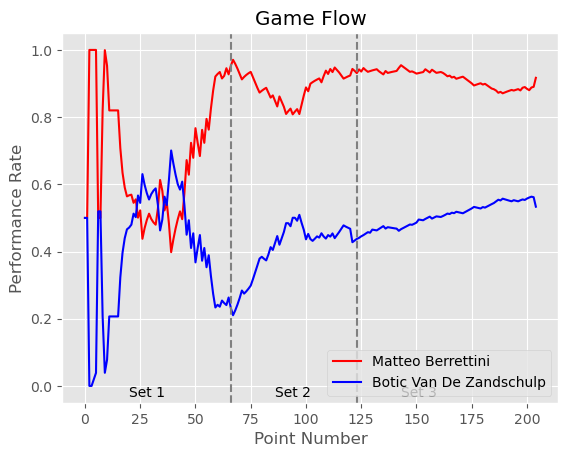

Matteo Berrettini is winning going into set 3 with:  0.9309055255733709 momentum
Matteo Berrettini won the game
The length of the match is: 3
[[1]
 [1]]


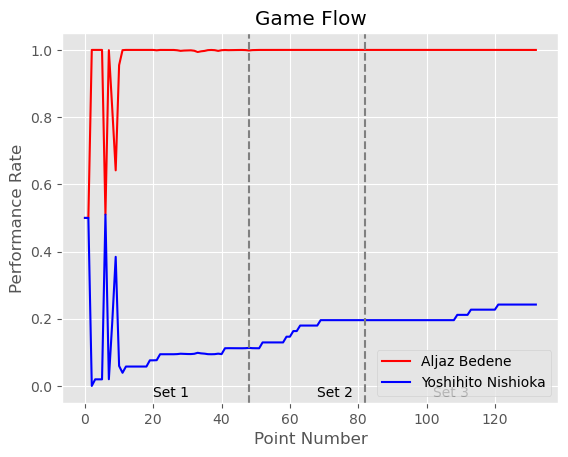

Aljaz Bedene is winning going into set 3 with:  0.9999996628125499 momentum
Aljaz Bedene won the game
The length of the match is: 3
[[1]
 [1]]


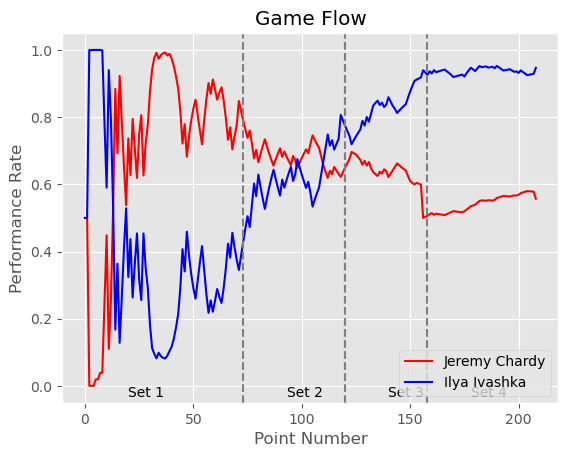

Ilya Ivashka is winning going into set 3 with:  0.7742062482634039 momentum
Ilya Ivashka is winning going into set 4 with:  0.925930733158481 momentum
Ilya Ivashka won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


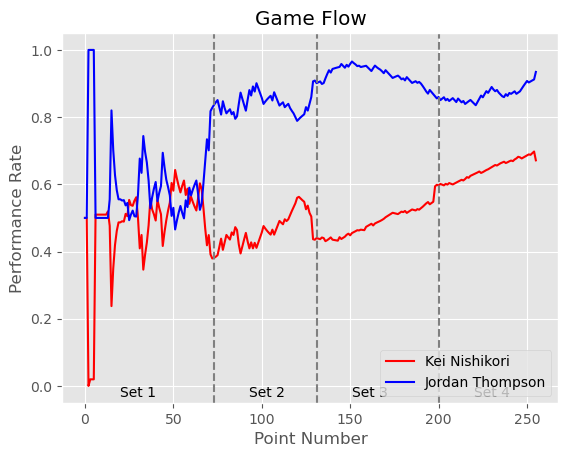

Jordan Thompson is winning going into set 3 with:  0.9012249913369565 momentum
Jordan Thompson is winning going into set 4 with:  0.860007798988478 momentum
Jordan Thompson won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


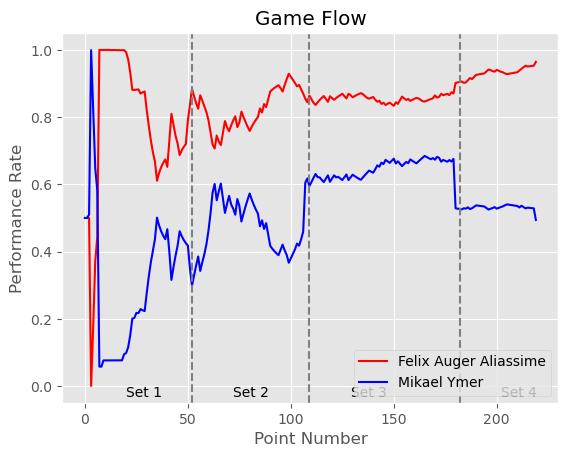

Felix Auger Aliassime is winning going into set 3 with:  0.8637816370492333 momentum
Felix Auger Aliassime is winning going into set 4 with:  0.9048615125159246 momentum
Felix Auger Aliassime won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


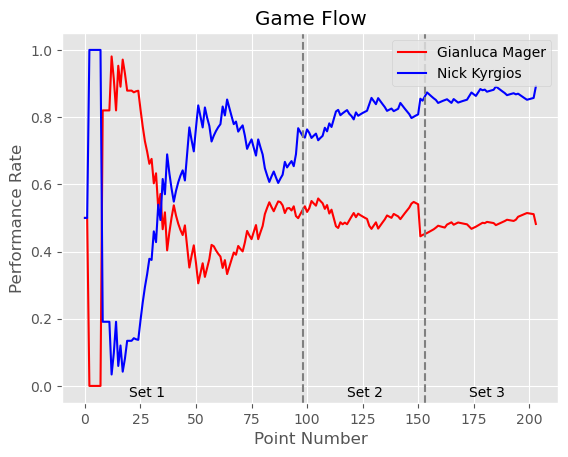

Nick Kyrgios is winning going into set 3 with:  0.8613054370020765 momentum
Nick Kyrgios won the game
The length of the match is: 3
[[1]
 [1]]


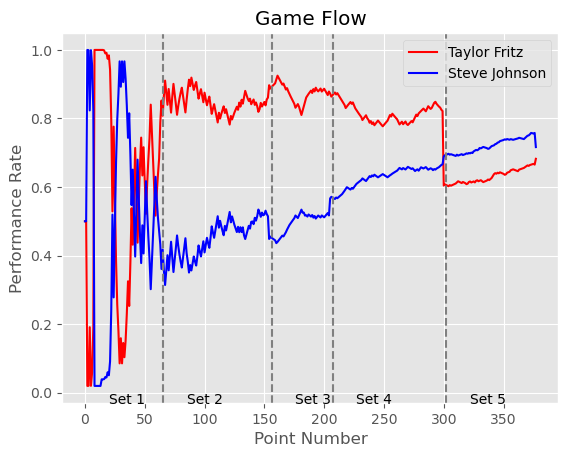

Taylor Fritz is winning going into set 3 with:  0.8914895397361532 momentum
Taylor Fritz is winning going into set 4 with:  0.8679649746993153 momentum
Steve Johnson is winning going into set 5 with:  0.6941594980065241 momentum
Taylor Fritz won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [0]]


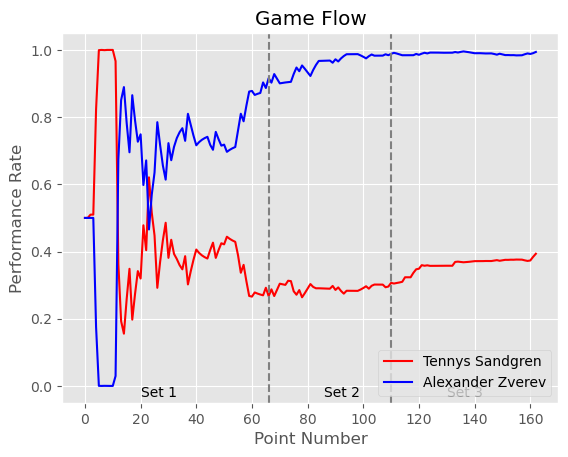

Alexander Zverev is winning going into set 3 with:  0.9882814220318169 momentum
Alexander Zverev won the game
The length of the match is: 3
[[1]
 [1]]


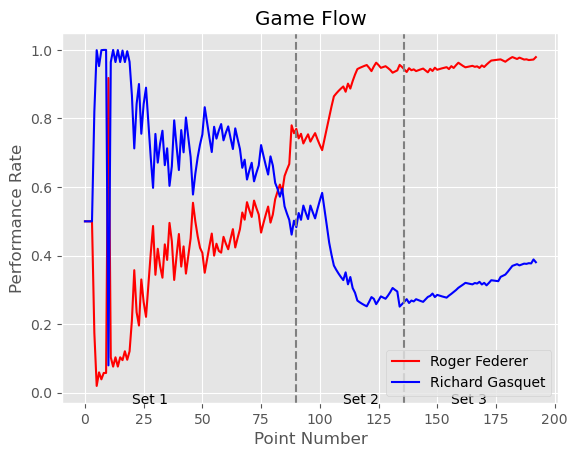

Roger Federer is winning going into set 3 with:  0.9430556877712948 momentum
Roger Federer won the game
The length of the match is: 3
[[1]
 [1]]


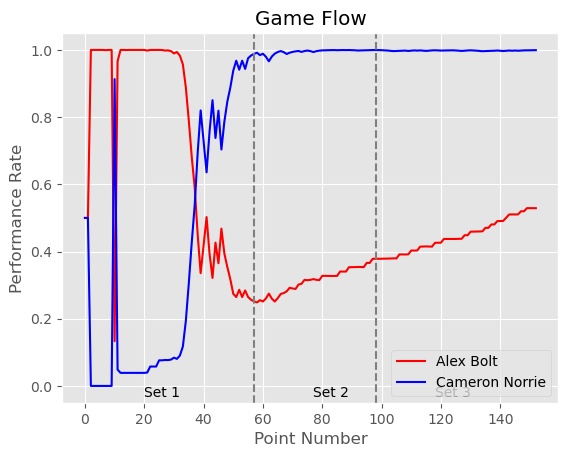

Cameron Norrie is winning going into set 3 with:  0.9997418418340354 momentum
Cameron Norrie won the game
The length of the match is: 3
[[1]
 [1]]


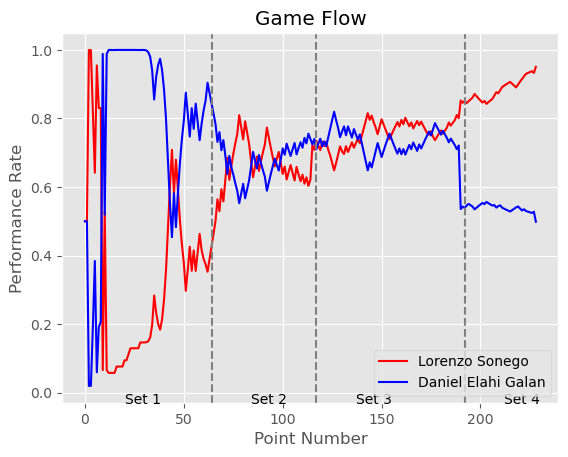

Lorenzo Sonego is winning going into set 3 with:  0.7344900384772706 momentum
Lorenzo Sonego is winning going into set 4 with:  0.851407533609188 momentum
Lorenzo Sonego won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


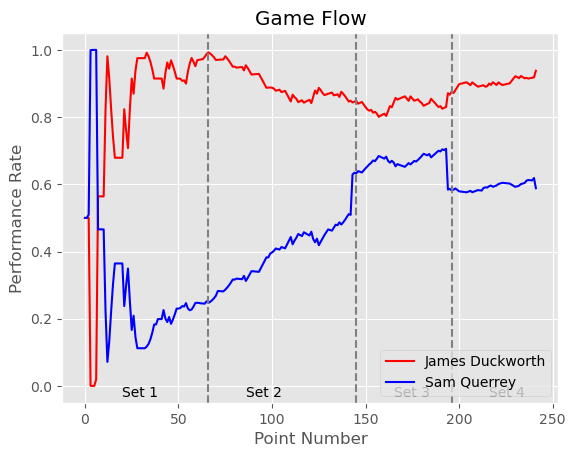

James Duckworth is winning going into set 3 with:  0.8482730972958089 momentum
James Duckworth is winning going into set 4 with:  0.8759393804150636 momentum
James Duckworth won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


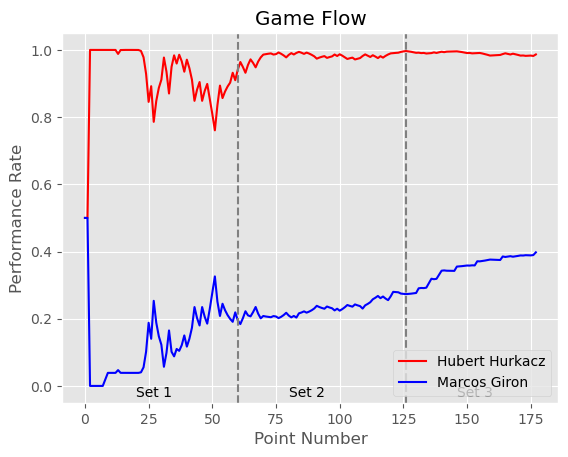

Hubert Hurkacz is winning going into set 3 with:  0.9967011581155598 momentum
Hubert Hurkacz won the game
The length of the match is: 3
[[1]
 [1]]


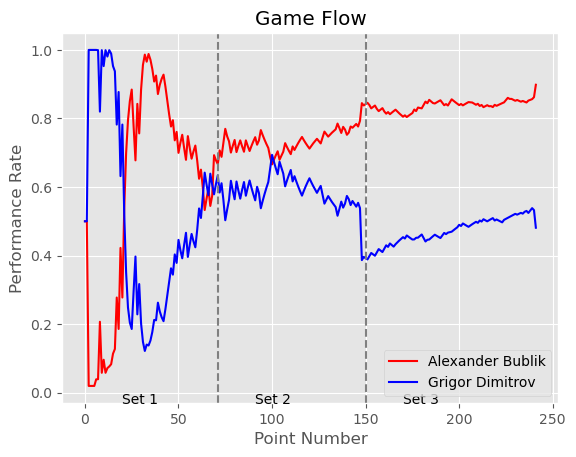

Alexander Bublik is winning going into set 3 with:  0.8419928963519997 momentum
Alexander Bublik won the game
The length of the match is: 3
[[1]
 [1]]


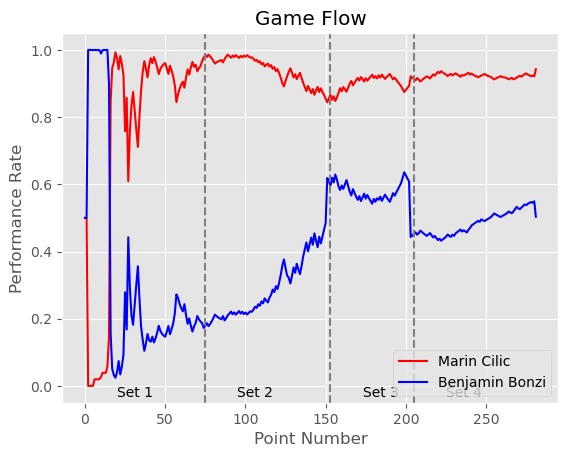

Marin Cilic is winning going into set 3 with:  0.8661396939741898 momentum
Marin Cilic is winning going into set 4 with:  0.913918116906382 momentum
Marin Cilic won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


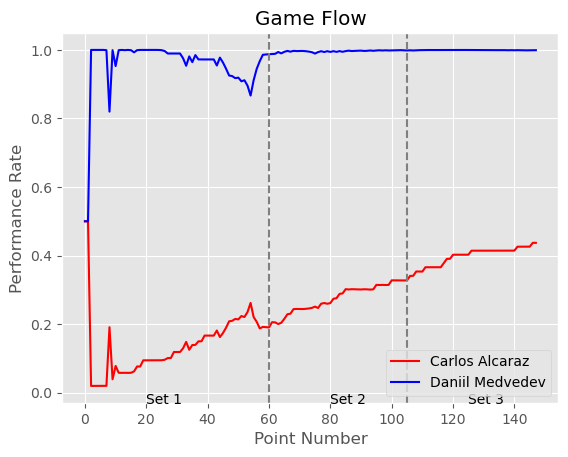

Daniil Medvedev is winning going into set 3 with:  0.9983819454015019 momentum
Daniil Medvedev won the game
The length of the match is: 3
[[1]
 [1]]


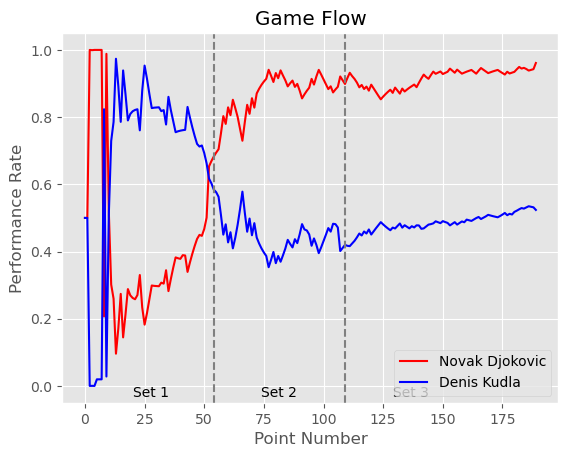

Novak Djokovic is winning going into set 3 with:  0.8986908367144044 momentum
Novak Djokovic won the game
The length of the match is: 3
[[1]
 [1]]


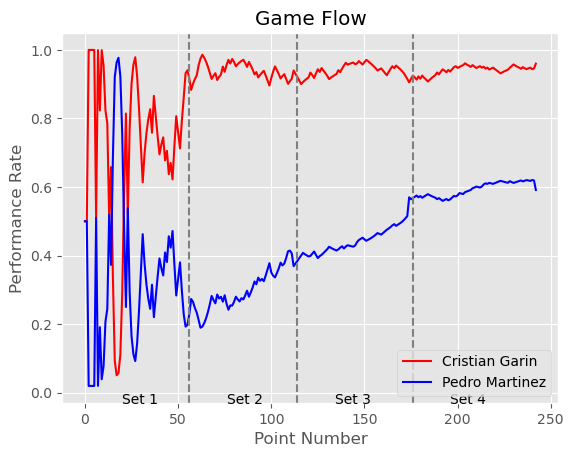

Cristian Garin is winning going into set 3 with:  0.9212486730463058 momentum
Cristian Garin is winning going into set 4 with:  0.9252350713128827 momentum
Cristian Garin won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


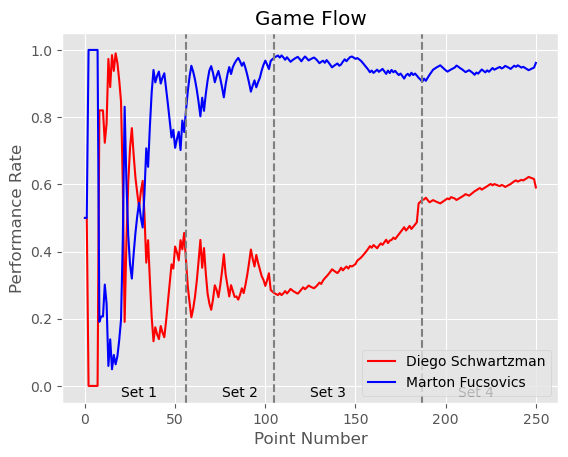

Marton Fucsovics is winning going into set 3 with:  0.9769692649611104 momentum
Marton Fucsovics is winning going into set 4 with:  0.905289492011004 momentum
Marton Fucsovics won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


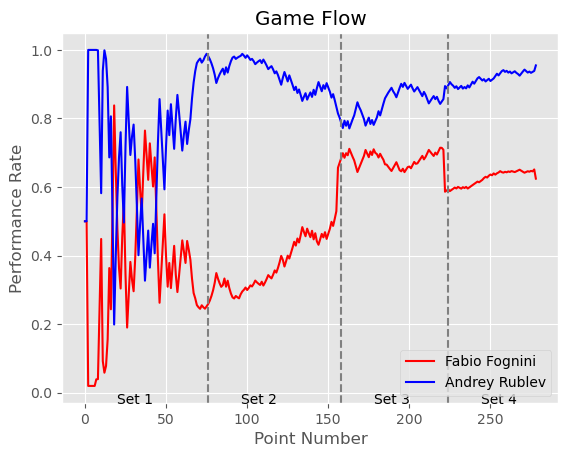

Andrey Rublev is winning going into set 3 with:  0.7871819952793928 momentum
Andrey Rublev is winning going into set 4 with:  0.8972399311413926 momentum
Andrey Rublev won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


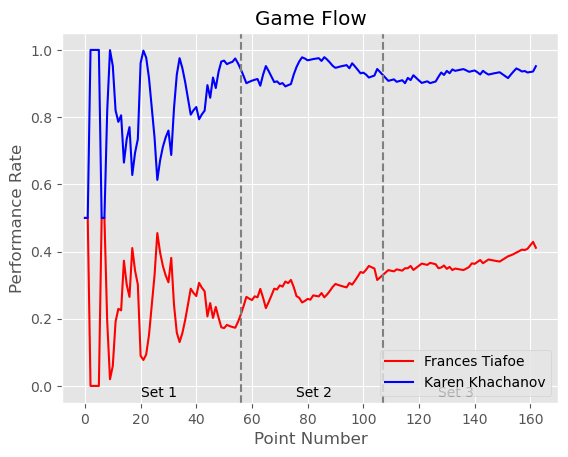

Karen Khachanov is winning going into set 3 with:  0.9256516089075534 momentum
Karen Khachanov won the game
The length of the match is: 3
[[1]
 [1]]


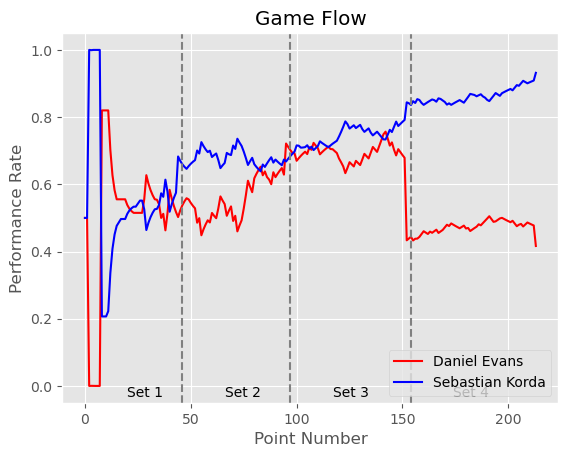

Daniel Evans is winning going into set 3 with:  0.7021279569588667 momentum
Sebastian Korda is winning going into set 4 with:  0.8360928430998235 momentum
Sebastian Korda won the game
The length of the match is: 4
[[1]
 [0]
 [1]]


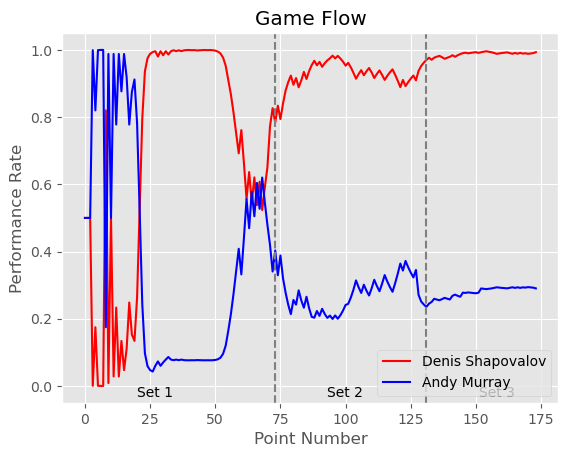

Denis Shapovalov is winning going into set 3 with:  0.9701093574234281 momentum
Denis Shapovalov won the game
The length of the match is: 3
[[1]
 [1]]


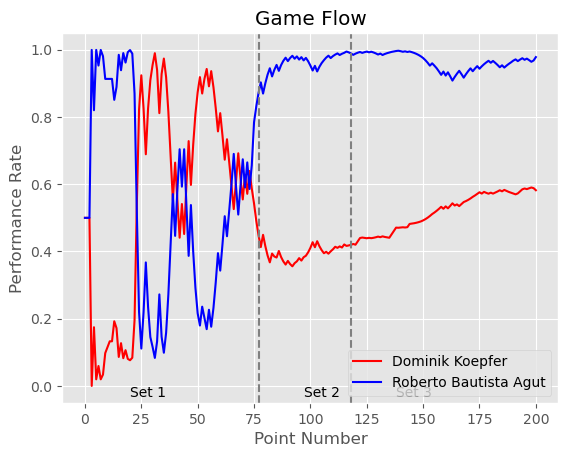

Roberto Bautista Agut is winning going into set 3 with:  0.9887849519441211 momentum
Roberto Bautista Agut won the game
The length of the match is: 3
[[1]
 [1]]


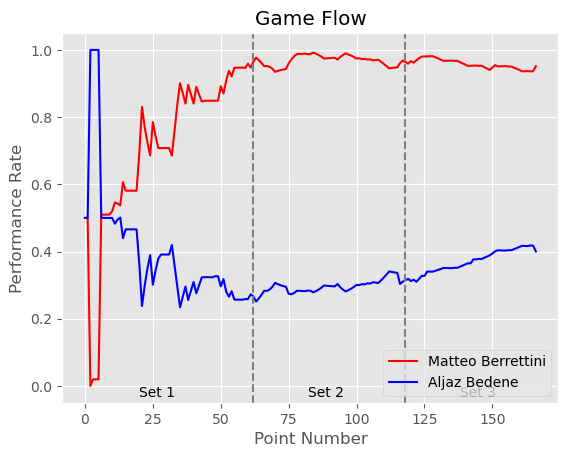

Matteo Berrettini is winning going into set 3 with:  0.9639092096179595 momentum
Matteo Berrettini won the game
The length of the match is: 3
[[1]
 [1]]


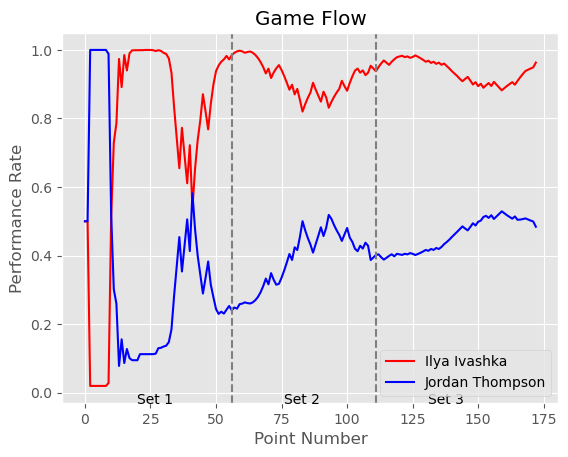

Ilya Ivashka is winning going into set 3 with:  0.9378384279993474 momentum
Ilya Ivashka won the game
The length of the match is: 3
[[1]
 [1]]


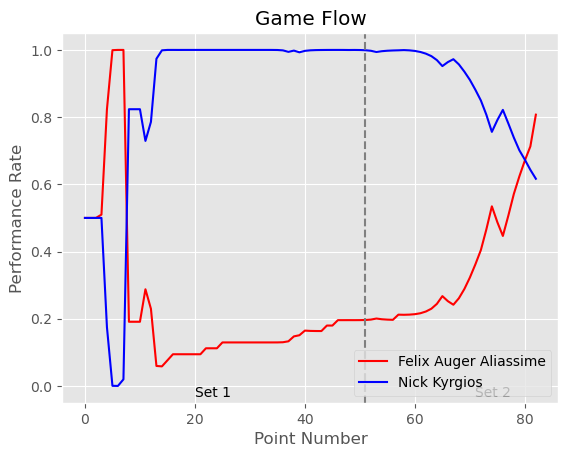

Felix Auger Aliassime won the game
The length of the match is: 2
[[0]]


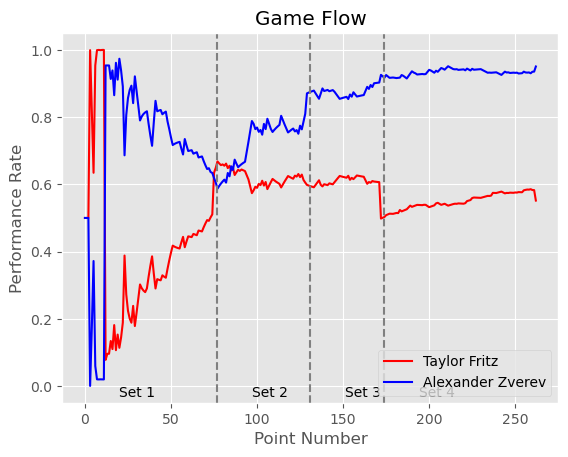

Alexander Zverev is winning going into set 3 with:  0.8752348179147449 momentum
Alexander Zverev is winning going into set 4 with:  0.9171903314290375 momentum
Alexander Zverev won the game
The length of the match is: 4
[[0]
 [1]
 [1]]


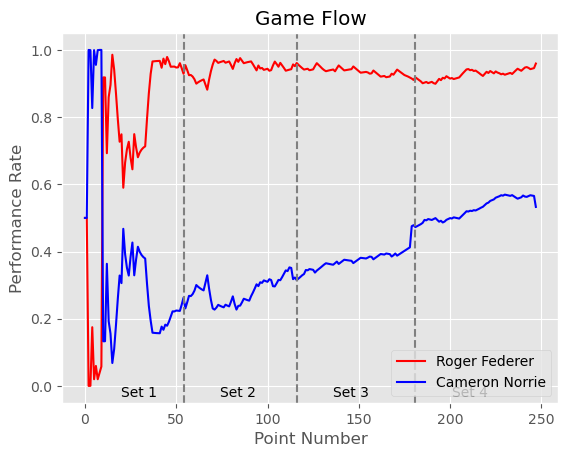

Roger Federer is winning going into set 3 with:  0.9610488338366787 momentum
Roger Federer is winning going into set 4 with:  0.9184191981235246 momentum
Roger Federer won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


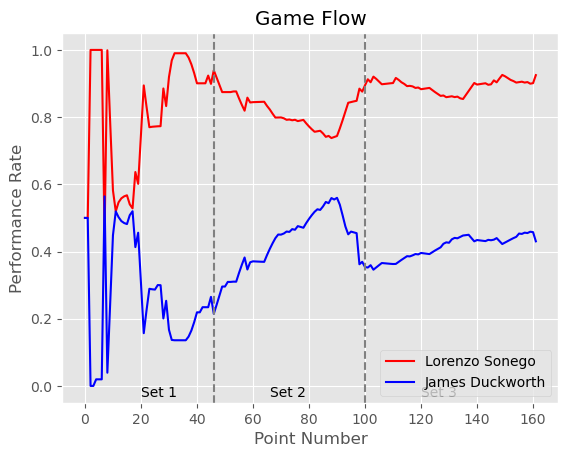

Lorenzo Sonego is winning going into set 3 with:  0.8946916953937535 momentum
Lorenzo Sonego won the game
The length of the match is: 3
[[1]
 [1]]


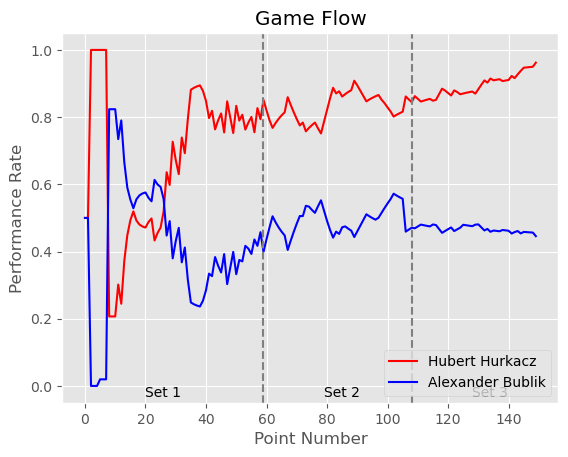

Hubert Hurkacz is winning going into set 3 with:  0.8444628895245516 momentum
Hubert Hurkacz won the game
The length of the match is: 3
[[1]
 [1]]


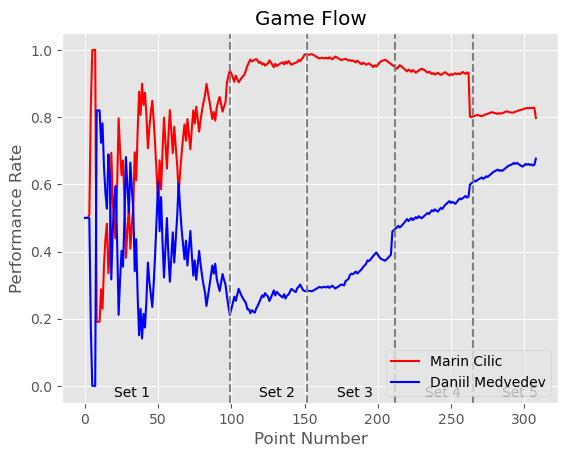

Marin Cilic is winning going into set 3 with:  0.9853246917521711 momentum
Marin Cilic is winning going into set 4 with:  0.9478014246759296 momentum
Marin Cilic is winning going into set 5 with:  0.8016726802423253 momentum
Daniil Medvedev won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [0]]


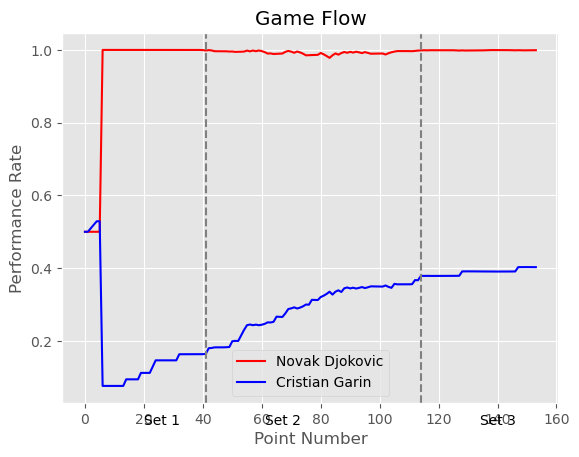

Novak Djokovic is winning going into set 3 with:  0.998739640263834 momentum
Novak Djokovic won the game
The length of the match is: 3
[[1]
 [1]]


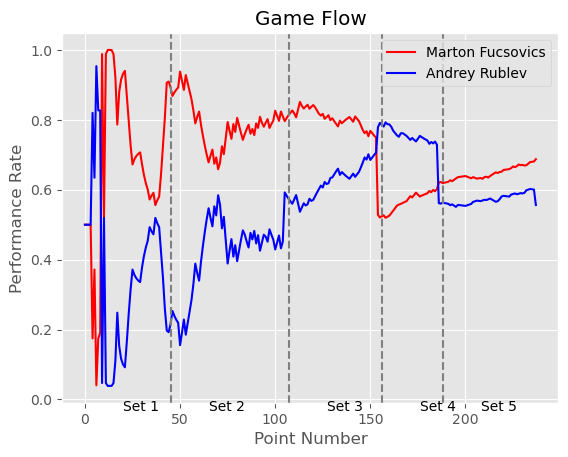

Marton Fucsovics is winning going into set 3 with:  0.8131670443161263 momentum
Andrey Rublev is winning going into set 4 with:  0.7857630786421055 momentum
Marton Fucsovics is winning going into set 5 with:  0.6189220578989791 momentum
Marton Fucsovics won the game
The length of the match is: 5
[[1]
 [1]
 [0]
 [1]]


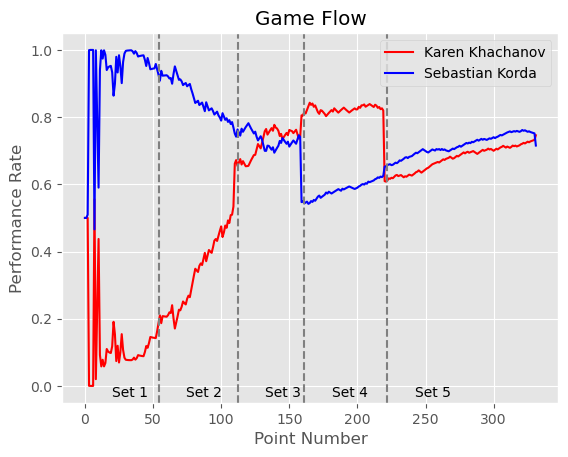

Sebastian Korda is winning going into set 3 with:  0.7633384362794928 momentum
Karen Khachanov is winning going into set 4 with:  0.8152729733306393 momentum
Sebastian Korda is winning going into set 5 with:  0.6574637836688308 momentum
Karen Khachanov won the game
The length of the match is: 5
[[0]
 [0]
 [1]
 [0]]


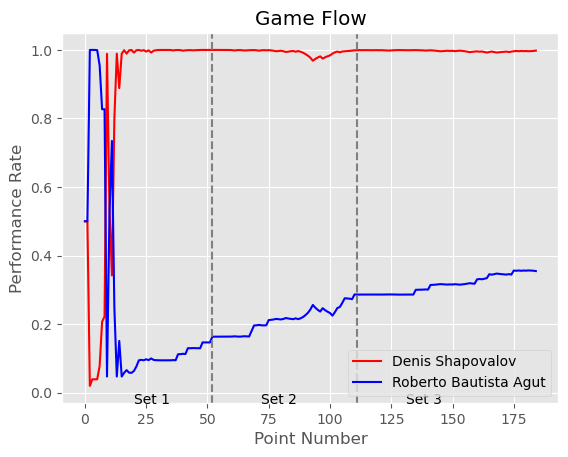

Denis Shapovalov is winning going into set 3 with:  0.9992176912124012 momentum
Denis Shapovalov won the game
The length of the match is: 3
[[1]
 [1]]


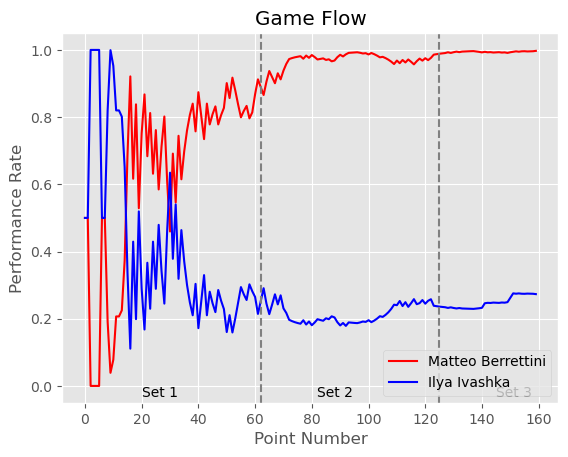

Matteo Berrettini is winning going into set 3 with:  0.98870322532704 momentum
Matteo Berrettini won the game
The length of the match is: 3
[[1]
 [1]]


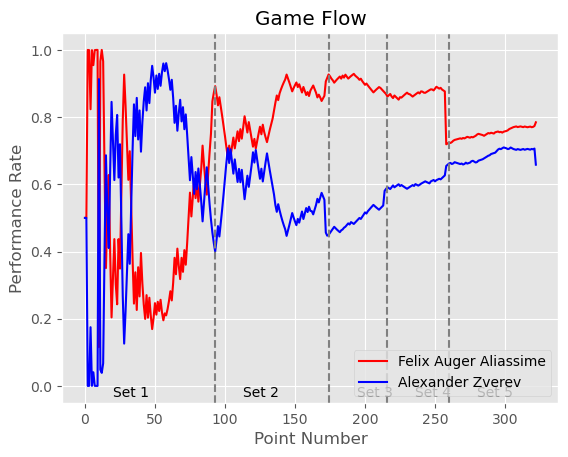

Felix Auger Aliassime is winning going into set 3 with:  0.9269491786737416 momentum
Felix Auger Aliassime is winning going into set 4 with:  0.861160514713138 momentum
Felix Auger Aliassime is winning going into set 5 with:  0.7243659170016054 momentum
Felix Auger Aliassime won the game
The length of the match is: 5
[[1]
 [1]
 [1]
 [1]]


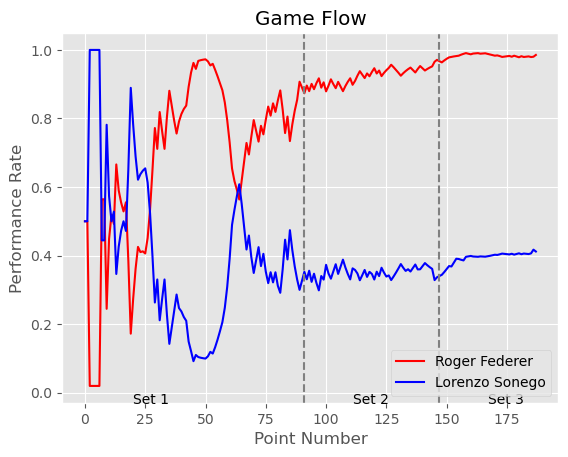

Roger Federer is winning going into set 3 with:  0.9670855543444743 momentum
Roger Federer won the game
The length of the match is: 3
[[1]
 [1]]


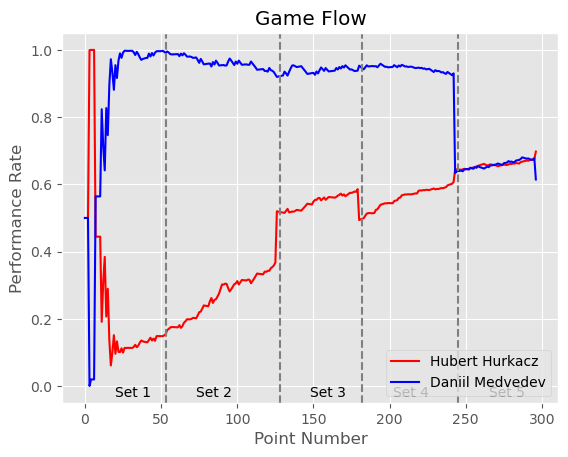

Daniil Medvedev is winning going into set 3 with:  0.9220328727880692 momentum
Daniil Medvedev is winning going into set 4 with:  0.9459692497158564 momentum
Hubert Hurkacz is winning going into set 5 with:  0.6442336429661266 momentum
Hubert Hurkacz won the game
The length of the match is: 5
[[0]
 [0]
 [0]
 [1]]


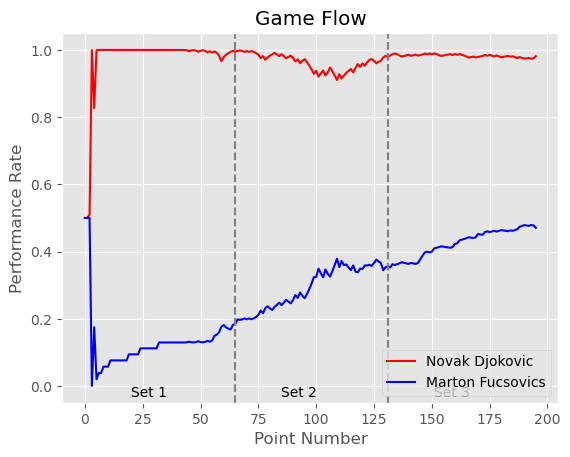

Novak Djokovic is winning going into set 3 with:  0.978534969439588 momentum
Novak Djokovic won the game
The length of the match is: 3
[[1]
 [1]]


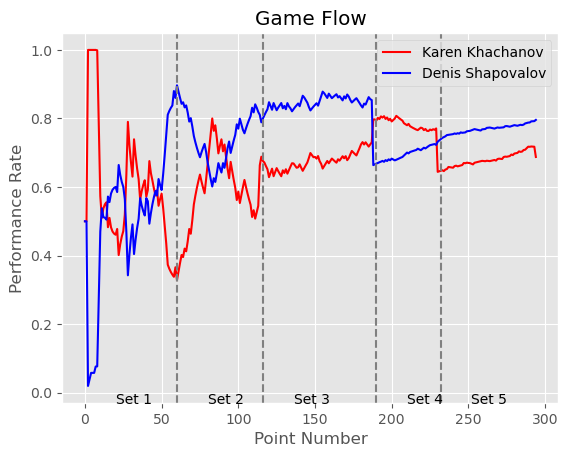

Denis Shapovalov is winning going into set 3 with:  0.7995821651648423 momentum
Karen Khachanov is winning going into set 4 with:  0.7938991103767139 momentum
Denis Shapovalov is winning going into set 5 with:  0.739666594635926 momentum
Denis Shapovalov won the game
The length of the match is: 5
[[1]
 [1]
 [0]
 [1]]


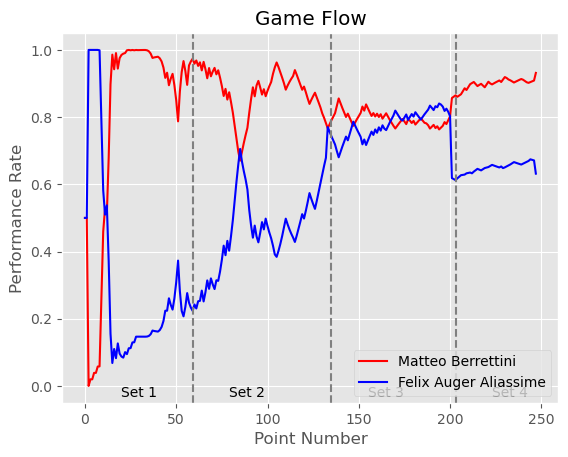

Matteo Berrettini is winning going into set 3 with:  0.7903979532464853 momentum
Matteo Berrettini is winning going into set 4 with:  0.8647595571892 momentum
Matteo Berrettini won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


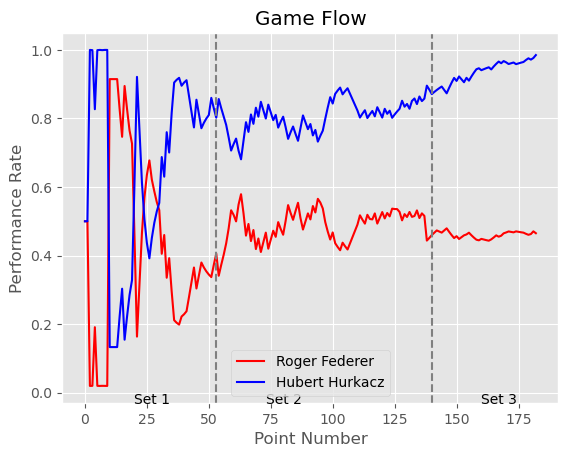

Hubert Hurkacz is winning going into set 3 with:  0.8710955296375825 momentum
Hubert Hurkacz won the game
The length of the match is: 3
[[1]
 [1]]


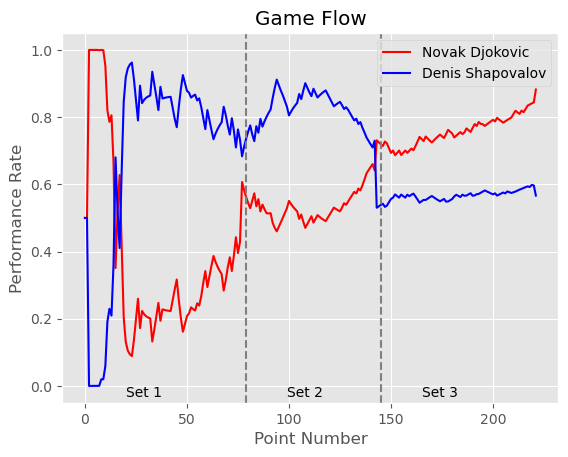

Novak Djokovic is winning going into set 3 with:  0.719257029690328 momentum
Novak Djokovic won the game
The length of the match is: 3
[[0]
 [1]]


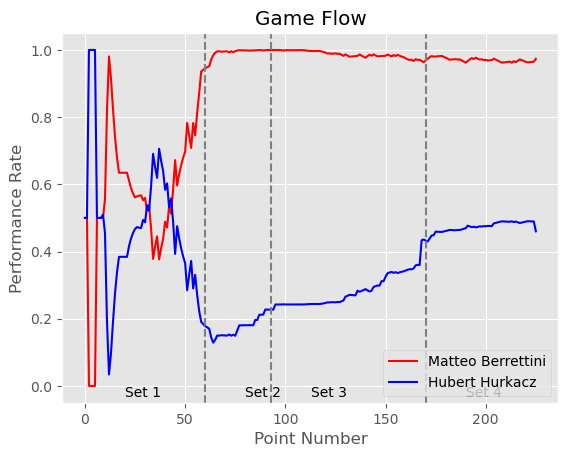

Matteo Berrettini is winning going into set 3 with:  0.9995884954234902 momentum
Matteo Berrettini is winning going into set 4 with:  0.9689067965583976 momentum
Matteo Berrettini won the game
The length of the match is: 4
[[1]
 [1]
 [1]]


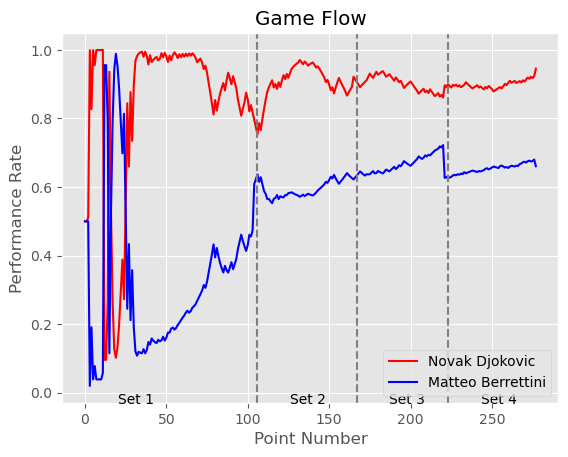

Novak Djokovic is winning going into set 3 with:  0.9068648846254931 momentum
Novak Djokovic is winning going into set 4 with:  0.8999280591180513 momentum
Novak Djokovic won the game
The length of the match is: 4
[[1]
 [1]
 [1]]
Predicted winner at set 2 correctly [96] / 125 times
Predicted winner at set 3 correctly [101] / 121 times
Predicted winner at set 4 correctly [52] / 68 times
Predicted winner at set 5 correctly [11] / 25 times


In [92]:
FILE = '2021-wimbledon-data.csv'
if False:
    # 2023 Matches
    MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                        '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                        '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                        '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']
if True:
    # 2021 Matches
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1101', '2021-wimbledon-1102', '2021-wimbledon-1103', '2021-wimbledon-1104', '2021-wimbledon-1105',
                        '2021-wimbledon-1106', '2021-wimbledon-1107', '2021-wimbledon-1108', '2021-wimbledon-1109', '2021-wimbledon-1110',
                        '2021-wimbledon-1111', '2021-wimbledon-1112', '2021-wimbledon-1113', '2021-wimbledon-1114', '2021-wimbledon-1115',
                        '2021-wimbledon-1116', '2021-wimbledon-1117', '2021-wimbledon-1118', '2021-wimbledon-1119', '2021-wimbledon-1120',
                        '2021-wimbledon-1121', '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1124', '2021-wimbledon-1125',
                        '2021-wimbledon-1126', '2021-wimbledon-1127', '2021-wimbledon-1128', '2021-wimbledon-1129', '2021-wimbledon-1130',
                        '2021-wimbledon-1131', '2021-wimbledon-1132', '2021-wimbledon-1133', '2021-wimbledon-1134', '2021-wimbledon-1135',
                        '2021-wimbledon-1136', '2021-wimbledon-1137', '2021-wimbledon-1138', '2021-wimbledon-1139', '2021-wimbledon-1140',
                        '2021-wimbledon-1141', '2021-wimbledon-1142', '2021-wimbledon-1143', '2021-wimbledon-1144', '2021-wimbledon-1145',
                        '2021-wimbledon-1146', '2021-wimbledon-1147', '2021-wimbledon-1148', '2021-wimbledon-1150', '2021-wimbledon-1151', 
                        '2021-wimbledon-1152', '2021-wimbledon-1153', '2021-wimbledon-1154', '2021-wimbledon-1155', '2021-wimbledon-1156', 
                        '2021-wimbledon-1157', '2021-wimbledon-1158', '2021-wimbledon-1159', '2021-wimbledon-1160', '2021-wimbledon-1161', 
                        '2021-wimbledon-1162', '2021-wimbledon-1163', '2021-wimbledon-1164', '2021-wimbledon-1201', '2021-wimbledon-1202', 
                        '2021-wimbledon-1203', '2021-wimbledon-1204', '2021-wimbledon-1205', '2021-wimbledon-1206', '2021-wimbledon-1207', 
                        '2021-wimbledon-1208', '2021-wimbledon-1209', '2021-wimbledon-1210', '2021-wimbledon-1211', '2021-wimbledon-1212', 
                        '2021-wimbledon-1214', '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1217', '2021-wimbledon-1218', 
                        '2021-wimbledon-1219', '2021-wimbledon-1220', '2021-wimbledon-1221', '2021-wimbledon-1222', '2021-wimbledon-1223', 
                        '2021-wimbledon-1224', '2021-wimbledon-1225', '2021-wimbledon-1226', '2021-wimbledon-1227', '2021-wimbledon-1228', 
                        '2021-wimbledon-1229', '2021-wimbledon-1230', '2021-wimbledon-1231', '2021-wimbledon-1232', '2021-wimbledon-1301', 
                        '2021-wimbledon-1302', '2021-wimbledon-1303', '2021-wimbledon-1304', '2021-wimbledon-1305', '2021-wimbledon-1306', 
                        '2021-wimbledon-1307', '2021-wimbledon-1308', '2021-wimbledon-1309', '2021-wimbledon-1310', '2021-wimbledon-1311', 
                        '2021-wimbledon-1312', '2021-wimbledon-1313', '2021-wimbledon-1314', '2021-wimbledon-1315', '2021-wimbledon-1316', 
                        '2021-wimbledon-1401', '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1404', '2021-wimbledon-1405', 
                        '2021-wimbledon-1406', '2021-wimbledon-1407', '2021-wimbledon-1408', '2021-wimbledon-1501', '2021-wimbledon-1502', 
                        '2021-wimbledon-1503', '2021-wimbledon-1504', '2021-wimbledon-1601', '2021-wimbledon-1602', '2021-wimbledon-1701']

set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0

for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
    model = MarkovChain(FILE, MATCH_TO_EXAMINE)
    model.train()
    model.graph_momentum()
    result_array = model.prediction()

    try:
        set1_correct += result_array[0]
        set1_total += 1

        set2_correct += result_array[1]
        set2_total += 1

        set3_correct += result_array[2]
        set3_total += 1

        set4_correct += result_array[3]
        set4_total += 1
    finally:
        continue

print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")